# A Data Analysis of College Women in STEM Studies

### Gioia Dominedo, Amy Lee and Kendrick Lo

<img src='img/header.jpg'>

# Table of Contents
1. [Background and Motivation](#section1)
2. [Data Collection](#section2)
3. [Exploratory Analysis](#section3)
4. [Feature Engineering](#section4)
5. [Logistic Regression](#section5)
6. [Random Forest](#section6)
7. [Discussion and Takeaways](#section7)

 <a id = "section1"></a>
 ##1. Background and Motivation

While women in the US today earn over 50% of bachelor's degrees, reports estimate that they only account for 25% or fewer of students earning degrees in science, technology, engineering and math (or STEM, for short). There has been no shortage of media coverage recently speculating about the causes of this imbalance, and discussing why it is an important issue. As STEM students ourselves, we strongly believe that including a more diverse range of people - not only women, but also other under-represented minorities - can enrich creativity and broaden the impact of innovation.

Armed with US Census microdata, we set out to investigate whether we could identify personal or household level features that make a female student more likely to choose to major in a STEM field, and to build a predictive model based on these features.

**Initial Questions:**
* Which personal and household level variables are correlated with a female student's decision to major in a STEM field or not?
* Can we use these variables to build regression and machine learning models that predict whether female students will major in a STEM field?
* Can we carry out peer analysis to determine whether these key variables differ across female and male students?
* Can we turn our classifiers into a prediction tool for female students' choice of major?
* Finally, can we identify key takeaways on how to encourage more female students to major in STEM subjects?

 <a id = "section2"></a>
 ##2. Data Collection

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
# Defined for easy access
colorPalette = sns.color_palette()
snsBlue = colorPalette[0]
snsGreen = colorPalette[1]
snsRed = colorPalette[2]
snsPurple = colorPalette[3]
snsYellow = colorPalette[4]
snsAzure = colorPalette[5]

###2.1 Data Source

The data for this project was obtained from the <a href='https://usa.ipums.org'>Integrated Public Use Microdata Series</a> (IPUMS), which is maintained by the University of Minnesota. IPUMS consists of sample microdata from US censuses dating back to 1850. The available data for each census represents approximately 1% of the total population.

The key advantage of working with this data is the incredibly high level of granularity, as we are working with individual records as opposed to working with summary census statistics. The main drawback is that the data only represents a small percentage of the overall population; however, the dataset is nonetheless very large (~3 million records per census). The number of potential features is also significant: for example there are 20+ demographic variables, 10+ education variables, 20+ income variables, etc.

We considered whether certain types of people might be more or less likely to respond to a census, thereby introducing bias to the data. However, responding to a census request is required by law, with a minimum fine of $5,000 for failing to complete the form or for answering questions falsely. For this reason we believe that any bias created by individual non-responses is likely to be negligible.

We chose to use data from the most recent US census, which was carried out in 2010. The data is not available via an API and can only be downloaded as an ASCII file, so we had to take the following steps in order to obtain a file that we could load into our iPython notebook.

* First, we submitted a query at the IPUMS-USA website for all available 2010 US census microdata. The result of the query was an ASCII data file and an associate STATA syntax file.
* We then loaded the ASCII data file into STATA (using the companion syntax file) and exported it as a CSV file (~12.2GB). A zipped version (~1.28GB) of this file is available <a href='https://copy.com/31nVAgdrBtZcgADm'>here</a>.

**Source:** Steven Ruggles, J. Trent Alexander, Katie Genadek, Ronald Goeken, Matthew B. Schroeder, and Matthew Sobek. Integrated Public Use Microdata Series: Version 5.0 [Machine-readable database]. Minneapolis, MN: Minnesota Population Center [producer and distributor], 2010.

###2.2 Identifying the Relevant Population

<div class="span5 alert alert-danger">
<strong>Note:</strong> The following lines of code require the entire 2010 US Census data file.
</div>

In [6]:
# this is all the US census microdata for 2010 before any filtering
df = pd.read_csv('data/acs_2010_all_fields.csv')

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (176,217,275,309) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [7]:
df.shape

(3061692, 434)

In [8]:
df.dtypes

rectype         object
year             int64
datanum          int64
serial           int64
numprec         object
subsamp         object
hhwt             int64
hhtype          object
repwt            int64
cluster          int64
adjust         float64
cpi99          float64
region          object
stateicp        object
statefip        object
county           int64
countyfips       int64
metro           object
metarea         object
metaread        object
city            object
cityerr         object
citypop          int64
puma             int64
pumares2mig      int64
strata           int64
pumasupr         int64
conspuma         int64
appal           object
appald          object
                ...   
repwtp51         int64
repwtp52         int64
repwtp53         int64
repwtp54         int64
repwtp55         int64
repwtp56         int64
repwtp57         int64
repwtp58         int64
repwtp59         int64
repwtp60         int64
repwtp61         int64
repwtp62         int64
repwtp63   

The first step was to identify the relevant population for our research question. We started by extracting all college undergraduates at the time of the census and adding indicator variables for:
* current college undergraduate
* female
* majoring in STEM (either primary or secondary field)

In [9]:
# let's just look at college students
college = df[df['gradeatt']=='College undergraduate']
college.shape

(168113, 434)

In [10]:
# get college students where main degreefield is not blank: 13,139 records
college_with_deg = college[college['degfield'] != '0']
college_with_deg.shape

(13139, 434)

In [11]:
# these are the subjects that are considered STEM
stem = ['Computer and Information Sciences', 'Engineering', 'Engineering Technologies', 
        'Biology and Life Sciences', 'Mathematics and Statistics', 'Physical Sciences', 
        'Nuclear, Industrial Radiology, and Biological Technologies']

In [12]:
cdeg = college_with_deg.copy()
cdeg['i_p_female'] = (college_with_deg.sex=='Female') * 1
cdeg['i_p_stem'] = (college_with_deg.degfield.isin(stem) | college_with_deg.degfield2.isin(stem)) * 1
cdeg['i_p_college'] = 1

In [13]:
cdeg.shape

(13139, 437)

Our research goal was to identify both personal and household characteristics that may influence a female student's decision to major in a STEM field, so the next step was to extract all the household members of those same college undergraduates.

In [14]:
# get unique household numbers of college undergrads
household_serial_num = cdeg.serial.unique()

In [15]:
len(household_serial_num)

12627

In [16]:
# get people in households, remove those in college undergrad to prevent duplicates with cdeg
household=df[df.serial.isin(household_serial_num)]
hh_nocollege = household[household['gradeatt']!='College undergraduate']

In [17]:
hh_nocollege.shape

(22525, 434)

In [18]:
# add same indicator variables
hh = hh_nocollege.copy()
hh['i_p_female'] = (hh.sex=='Female') * 1
hh['i_p_stem'] = (hh.degfield.isin(stem) | hh.degfield2.isin(stem)) * 1
hh['i_p_college'] = 0

Finally, we combined the two dataframes into a single dataframe and save it for later use.

In [19]:
dftouse = pd.concat([hh, cdeg])

In [20]:
dftouse.shape

(35664, 437)

In [21]:
dftouse.head()

,rectype,year,datanum,serial,numprec,subsamp,hhwt,hhtype,repwt,cluster,adjust,cpi99,region,stateicp,statefip,county,countyfips,metro,metarea,metaread,city,cityerr,citypop,puma,pumares2mig,strata,pumasupr,conspuma,appal,appald,homeland,cntry,gq,gqtype,gqtyped,farm,ownershp,ownershpd,mortgage,mortgag2,commuse,farmprod,acrehous,mortamt1,mortamt2,taxincl,insincl,propinsr,proptx99,owncost,...,repwtp34,repwtp35,repwtp36,repwtp37,repwtp38,repwtp39,repwtp40,repwtp41,repwtp42,repwtp43,repwtp44,repwtp45,repwtp46,repwtp47,repwtp48,repwtp49,repwtp50,repwtp51,repwtp52,repwtp53,repwtp54,repwtp55,repwtp56,repwtp57,repwtp58,repwtp59,repwtp60,repwtp61,repwtp62,repwtp63,repwtp64,repwtp65,repwtp66,repwtp67,repwtp68,repwtp69,repwtp70,repwtp71,repwtp72,repwtp73,repwtp74,repwtp75,repwtp76,repwtp77,repwtp78,repwtp79,repwtp80,i_p_female,i_p_stem,i_p_college
168,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,53,107,14,57,59,65,57,58,88,101,56,52,60,92,16,101,53,15,17,14,58,107,15,55,56,58,56,48,97,89,54,66,56,89,17,102,51,16,15,14,59,96,16,55,54,54,53,1,0,0
169,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,78,180,28,87,101,103,94,91,155,136,70,94,107,138,19,155,79,26,29,29,95,167,29,84,84,92,101,72,122,151,96,93,74,152,24,199,98,24,28,24,83,152,28,91,93,85,88,0,0,0
170,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,67,144,17,80,76,84,68,74,134,111,66,66,98,100,17,125,71,19,23,19,73,107,21,73,65,68,68,62,119,168,73,63,64,117,21,117,84,17,20,18,66,131,22,74,64,65,60,1,0,0
230,H,2010,1,105,3,81,62,"Male householder, no wife present",1,2010000001051,1.007624,0.764,East South Central Div.,Alabama,Alabama,0,0,"In metro area, central / principal city","Montgomery, AL","Montgomery, AL","Montgomery, AL",0%,2067,1900,19,190001,1500,5,Not in Appalachia,Not in Appalachia,PUMA does not include a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed

In [24]:
# save smaller dataframe for later use
dftouse.to_csv('data/dftouse3.csv') 

<div class="span5 alert alert-success">
<strong>Note:</strong> From this point on, all the code can be run using the web links to the relevant CSV files.
</div>

 <a id = "section3"></a>
 ##3. Exploratory Analysis

Before going any further, we carried out exploratory data analysis on the college students in our dataset using <a href='http://www.tableau.com/'>Tableau Desktop</a>.

It is worth noting that all the visualizations below only relate to the sub-sample of 13,139 college students in our dataset, and are not necessarily completely representative of the entire US college population.

**Are women going to college?**

<img src='img/college_gender.png' width=75%>

Women are not shying away from higher education. That's great!

**Are women getting into STEM programs?**

<img src='img/college_stem_gender.png' width=65%>

While female students account for nearly two-thirds of students majoring in non-STEM subjects, they only represent 42% of students majoring in STEM subjects. Still, that's not too bad.  But what if you look at it in a different way?

<img src='img/stem_female.png' width=55%>

Only 13% of female college students choose to pursue studies in a STEM major.

**Does the age distribution of STEM and non-STEM majors vary?**

<img src='img/women_stem_age.png' width=80%>

We were surprised the see the very wide distribution of ages for college students, and decided to explore this further in later steps.

**Does the race of STEM and non-STEM majors vary?**

<img src='img/race_bar.png' width=80%>

<img src='img/race_table.png' width=75%>

<img src='img/race_pies.png' width=80%>

At first glance, Chinese students seem to be the largest proportion (about one third) and Native American the lowest (less than 5%), though some sub-samples are too small to make any reasonable inference. Most others are in the 10-20% range.

**Does the first language of STEM and non-STEM majors vary?**

<img src='img/lang_logbar.png' width=80%>

<img src='img/lang_logcircle.png' width=90%>

There were no major insights to be gained from this graph.

**Does the family composition of STEM and non-STEM majors vary?**

<img src='img/famsize.png' width=80%>

<img src='img/siblings.png' width=55%>

It is unclear whether these provide any interesting insights without further analysis. In particular, it is important to note that the data only considers family members **within the same household**, so it may or may not capture the size and make-up of an individual's immediate family depending on whether they are living within the same household. It will be worth bearing this is mind when analyzing household level features.

**Do the economic characteristics of STEM and non-STEM majors vary?**

<img src='img/income_hist.png' width=85%>

<img src='img/income_pies.png' width=80%>

The first two graphs are skewed toward lower incomes, which is not surprising. We had originally suspected that there might be an association between income levels and the choice of fields of study - if there is, it is not clear from these graphs.

<img src='img/stem_mean.png' width=25%>

<img src='img/stem_hh.png' width=60%>

In further examining the income distribution, we noticed that there were a few 999999 values that were distorting results so we made a note to examine this in more detail later.

<img src='img/poverty.png' width=70%>

The above graph presents family income as a percentage of the poverty threshold. Not surprisingly, we found that there are more people in college from higher income families, which is consistent with these families being able to afford to send their children to college.

<img src='img/poverty_circles.png' width=60%>

We found that the previous graph was a bit misleading with respect to points less than the poverty threshold, so we converted to 'above the threshold' and 'below the threshold' in the above graph. We found this a clearer way to display the much larger proportion of students from families above the proverty line, regardless of their choice of major.

**Do the geographic characteristics of STEM and non-STEM majors vary?**

<img src='img/metro.png' width=35%>

<img src='img/map_1.png' width=90%>

<img src='img/map_2.png' width=90%>

<img src='img/map_3.png' width=35%>

We initially speculated that students living in areas that are more exposed to STEM fields (e.g. near technology hubs) may be more likely to study such subjects themselves. However, we there does not seem to be any noticeable difference by state.

When examining these graphs, we also considered that individuals in different life circumstances may be classified under either their "home" state or the state where they are living to attend college, making a like-for-like comparison more difficult.

 <a id = "section4"></a>
 ##4. Feature Engineering

###4.1 Feature Engineering - Individual Records

By this point, we had reduced our dataset to ~13,000 college students with a declared major and ~22,000 individuals that are part of those students' households. The next step was to examine the data for any data quality issues (e.g. missing data or inconsistent types) and to narrow down the full list of 434 features in order to reduce the complexity of the prediction models that we planned to build.

In [4]:
# use locally stored file
df3 = pd.read_csv('data/dftouse3.csv')

# use web-based file (~142MB)
# df3 = pd.read_csv('https://copy.com/66pRRJSh1jDtNczk')

df3 = df3.drop('Unnamed: 0', axis=1)

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (5,197,218,276) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [5]:
df3.shape

(35664, 437)

In [6]:
# sort by household for easier viewing
df3 = df3.sort(['serial', 'pernum']).reset_index(drop=True)
df3.head()

,rectype,year,datanum,serial,numprec,subsamp,hhwt,hhtype,repwt,cluster,adjust,cpi99,region,stateicp,statefip,county,countyfips,metro,metarea,metaread,city,cityerr,citypop,puma,pumares2mig,strata,pumasupr,conspuma,appal,appald,homeland,cntry,gq,gqtype,gqtyped,farm,ownershp,ownershpd,mortgage,mortgag2,commuse,farmprod,acrehous,mortamt1,mortamt2,taxincl,insincl,propinsr,proptx99,owncost,...,repwtp34,repwtp35,repwtp36,repwtp37,repwtp38,repwtp39,repwtp40,repwtp41,repwtp42,repwtp43,repwtp44,repwtp45,repwtp46,repwtp47,repwtp48,repwtp49,repwtp50,repwtp51,repwtp52,repwtp53,repwtp54,repwtp55,repwtp56,repwtp57,repwtp58,repwtp59,repwtp60,repwtp61,repwtp62,repwtp63,repwtp64,repwtp65,repwtp66,repwtp67,repwtp68,repwtp69,repwtp70,repwtp71,repwtp72,repwtp73,repwtp74,repwtp75,repwtp76,repwtp77,repwtp78,repwtp79,repwtp80,i_p_female,i_p_stem,i_p_college
0,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,58,103,14,72,63,56,63,66,92,97,67,59,62,82,18,104,62,17,16,20,71,101,17,72,72,51,49,63,132,134,70,62,56,96,20,117,59,18,17,16,56,95,18,55,58,64,55,0,1,1
1,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,53,107,14,57,59,65,57,58,88,101,56,52,60,92,16,101,53,15,17,14,58,107,15,55,56,58,56,48,97,89,54,66,56,89,17,102,51,16,15,14,59,96,16,55,54,54,53,1,0,0
2,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt","Yes, 2nd mortgage",No commerical use,0,House on less than 10 acres,800,1500,No,No,200,$ 650 - 699,2575,...,78,180,28,87,101,103,94,91,155,136,70,94,107,138,19,155,79,26,29,29,95,167,29,84,84,92,101,72,122,151,96,93,74,152,24,199,98,24,28,24,83,152,28,91,93,85,88,0,0,0
3,H,2010,1,80,4,97,60,Married-couple family household,1,2010000000801,1.007624,0.764,East South Central Div.,Alabama,Alabama,730,73,Central / Principal city status unknown,"Birmingham, AL","Birmingham, AL",Not in identifiable city (or size group),Not Applicable (no city identified),0,904,9,90401,1702,4,Southern Appalachia,Southern Appalachia,PUMA includes a homeland area,United States,Households under 1970 definition,NA (non-group quarters households),NA (non-group quarters households),Non-Farm,Owned or being bought (loan),Owned with mortgage

**4.1.1 Delete Fields**

We used the US Census documentation to familarize ourselves with the many variables and to identify the most relevant ones for our research question. Our findings and rationale for excluding fields are summarized <a href='doc/excluded_features.md'>here</a>.

In [7]:
columns_to_drop = ['related', 'rectype', 'year', 'datanum', 'numprec', 'subsamp', 'hhtype', 'repwt', 
                   'cluster', 'adjust', 'cpi99', 'region', 'stateicp', 'statefip', 'county', 'countyfips',
                   'metro', 'metarea', 'metaread', 'city', 'cityerr', 'citypop', 'puma', 'pumares2mig',
                   'strata', 'pumasupr', 'conspuma','appal', 'appald', 'homeland', 'cntry', 'gq', 'gqtype',
                   'gqtyped', 'farm', 'ownershp', 'mortgag2','commuse', 'farmprod', 'acrehous', 'mortamt1',
                   'mortamt2', 'taxincl', 'insincl', 'propinsr', 'proptx99', 'owncost', 'rentgrs', 'rentmeal',
                   'condofee', 'moblhome', 'costfuel', 'vacancy', 'kitchen', 'fridge', 'sink', 'stove', 'rooms',
                   'plumbing', 'hotwater', 'shower', 'toilet','builtyr2', 'unitsstr', 'phone', 'fuelheat',
                   'nsubfam', 'ncouples', 'multgend', 'cbnsubfam', 'repwt1', 'repwt2', 'repwt3', 'repwt4',
                   'repwt5', 'repwt6', 'repwt7', 'repwt8', 'repwt9', 'repwt10', 'repwt11', 'repwt12', 'repwt13',
                   'repwt14', 'repwt15', 'repwt16', 'repwt17', 'repwt18', 'repwt19', 'repwt20', 'repwt21', 
                   'repwt22', 'repwt23', 'repwt24', 'repwt25', 'repwt26', 'repwt27', 'repwt28', 'repwt29',
                   'repwt30', 'repwt31', 'repwt32', 'repwt33', 'repwt34', 'repwt35', 'repwt36', 'repwt37',
                   'repwt38', 'repwt39', 'repwt40', 'repwt41', 'repwt42', 'repwt43', 'repwt44', 'repwt45', 
                   'repwt46', 'repwt47', 'repwt48', 'repwt49', 'repwt50', 'repwt51', 'repwt52', 'repwt53',
                   'repwt54', 'repwt55', 'repwt56', 'repwt57', 'repwt58', 'repwt59', 'repwt60', 'repwt61',
                   'repwt62', 'repwt63', 'repwt64', 'repwt65', 'repwt66', 'repwt67', 'repwt68', 'repwt69',
                   'repwt70', 'repwt71', 'repwt72', 'repwt73', 'repwt74', 'repwt75', 'repwt76', 'repwt77',
                   'repwt78', 'repwt79', 'repwt80', 'respmode', 'slwt', 'repwtp', 'nchlt5', 'famunit', 
                   'eldch', 'yngch', 'stepmom', 'momrule', 'steppop', 'poprule', 'sprule', 'subfam', 'sftype',
                   'sfrelate', 'cbsubfam', 'cbsftype','cbsfrelate', 'relate', 'sex', 'birthqtr', 'birthyr',
                   'marrno', 'marrinyr', 'yrmarr', 'divinyr', 'widinyr', 'fertyr', 'race', 'raced', 'hispand',
                   'bpld', 'ancestr1', 'ancestr1d', 'ancestr2', 'ancestr2d', 'yrnatur',
                   'yrsusa1', 'yrsusa2', 'languaged', 'tribe', 'tribed', 'racesing', 'racesingd', 'racnum',
                   'hcovpriv', 'hinsemp', 'hinspur', 'hinstri', 'hcovpub', 'hinscaid', 'hinscare', 'hinsva', 
                   'hinsihs', 'hiufpgbase', 'hiufpginc', 'hiurule', 'hiuid', 'hiunpers', 'educ', 'gradeatt',
                   'gradeattd', 'degfield', 'degfieldd', 'degfield2', 'degfield2d', 'empstatd', 'labforce', 
                   'occ1950', 'occ1990', 'occ2010', 'ind', 'ind1950', 'ind1990', 'classwkr', 'occsoc',
                   'indnaics', 'wkswork2', 'uhrswork', 'absent', 'looking', 'availble', 'wrkrecal', 'workedyr',
                   'ftotinc', 'incwage', 'incbus00', 'incss', 'incwelfr', 'incinvst', 'incretir', 'incsupp',
                   'incother', 'incearn', 'occscore', 'sei', 'hwsei', 'presgl', 'prent', 'erscor50', 'erscor90',
                   'edscor50', 'edscor90', 'npboss50', 'npboss90', 'migrate1', 'migrate1d', 'migplac1',
                   'migmet1', 'migtype1', 'migcity1', 'migpums1', 'migpuma1', 'movedin', 'vetstat', 'vet01ltr',
                   'vet90x01', 'vet75x90', 'vet80x90', 'vet75x80', 'vetvietn', 'vet55x64', 'vetkorea',
                   'vet47x50', 'vetwwii', 'vetother', 'pwstate2', 'pwmetro', 'pwcity', 'pwtype', 'pwpuma00',
                   'pwpumas', 'tranwork', 'carpool', 'riders', 'trantime', 'departs', 'arrives', 'gchouse',
                   'gcmonths', 'gcrespon', 'probai', 'probapi', 'probblk', 'proboth', 'probwht', 'repwtp1',
                   'repwtp2', 'repwtp3', 'repwtp4', 'repwtp5', 'repwtp6', 'repwtp7', 'repwtp8', 'repwtp9',
                   'repwtp10', 'repwtp11', 'repwtp12','repwtp13', 'repwtp14', 'repwtp15', 'repwtp16', 'repwtp17',
                   'repwtp18', 'repwtp19', 'repwtp20', 'repwtp21', 'repwtp22', 'repwtp23', 'repwtp24', 'repwtp25',
                   'repwtp26', 'repwtp27', 'repwtp28', 'repwtp29', 'repwtp30', 'repwtp31', 'repwtp32', 'repwtp33',
                   'repwtp34', 'repwtp35', 'repwtp36', 'repwtp37', 'repwtp38', 'repwtp39', 'repwtp40', 'repwtp41',
                   'repwtp42', 'repwtp43', 'repwtp44', 'repwtp45', 'repwtp46', 'repwtp47', 'repwtp48', 'repwtp49',
                   'repwtp50', 'repwtp51', 'repwtp52', 'repwtp53', 'repwtp54', 'repwtp55', 'repwtp56', 'repwtp57', 
                   'repwtp58', 'repwtp59', 'repwtp60', 'repwtp61', 'repwtp62', 'repwtp63', 'repwtp64', 'repwtp65',
                   'repwtp66', 'repwtp67', 'repwtp68', 'repwtp69', 'repwtp70', 'repwtp71', 'repwtp72', 'repwtp73',
                   'repwtp74', 'repwtp75', 'repwtp76', 'repwtp77', 'repwtp78', 'repwtp79', 'repwtp80']

In [8]:
# focus on key fields
df3_firstpass = df3.drop(columns_to_drop, axis=1)
df3_firstpass.head()

,serial,hhwt,ownershpd,mortgage,rent,costelec,costgas,costwatr,hhincome,foodstmp,valueh,lingisol,bedrooms,vehicles,nfams,nmothers,nfathers,multgen,pernum,perwt,famsize,nchild,nsibs,momloc,poploc,sploc,age,marst,hispan,bpl,citizen,yrimmig,language,speakeng,racamind,racasian,racblk,racpacis,racwht,racother,hcovany,school,educd,schltype,empstat,occ,classwkrd,inctot,poverty,vetdisab,diffrem,diffphys,diffmob,diffcare,diffsens,diffeye,diffhear,vetstatd,i_p_female,i_p_stem,i_p_college
0,80,60,Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt",0,2400,9993,30,87000,No,165000,Not linguistically isolated,3,3,1 family or N/A,1,1,2 generations,1,60,4,2,0 siblings,0,0,2,33,"Married, spouse present",Not Hispanic,Alabama,NaN,0,English,"Yes, speaks only English",No,No,Yes,No,No,No,With health insurance coverage,"Yes, in school",Bachelor's degree,Public school,Employed,1360,"Wage/salary, private",45000,396,NaN,No cognitive difficulty,No ambulatory difficulty,No independent living difficulty,No,No vision or hearing difficulty,No,No,No military service,0,1,1
1,80,60,Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt",0,2400,9993,30,87000,No,165000,Not linguistically isolated,3,3,1 family or N/A,1,1,2 generations,2,56,4,2,0 siblings,0,0,1,27,"Married, spouse present",Not Hispanic,Alabama,NaN,0,English,"Yes, speaks only English",No,No,Yes,No,No,No,With health insurance coverage,"No, not in school","Associate's degree, type not specified",Not enrolled,Employed,3500,"Wage/salary, private",42000,396,NaN,No cognitive difficulty,No ambulatory difficulty,No independent living difficulty,No,No vision or hearing difficulty,No,No,No military service,1,0,0
2,80,60,Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt",0,2400,9993,30,87000,No,165000,Not linguistically isolated,3,3,1 family or N/A,1,1,2 generations,3,88,4,0 children present,1 sibling,2,1,0,Less than 1 year old,Never married/single,Not Hispanic,Alabama,NaN,0,N/A or blank,N/A (Blank),No,No,Yes,No,No,No,With health insurance coverage,NaN,NaN,NaN,NaN,0,NaN,9999999,396,NaN,NaN,NaN,NaN,NaN,No vision or hearing difficulty,No,No,NaN,0,0,0
3,80,60,Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt",0,2400,9993,30,87000,No,165000,Not linguistically isolated,3,3,1 family or N/A,1,1,2 generations,4,69,4,0 children present,1 sibling,2,1,0,Less than 1 year old,Never married/single,Not Hispanic,Alabama,NaN,0,N/A or blank,N/A (Blank),No,No,Yes,No,No,No,With health insurance coverage,NaN,NaN,NaN,NaN,0,NaN,9999999,396,NaN,NaN,NaN,NaN,NaN,No vision or hearing difficulty,No,No,NaN,1,0,0
4,105,62,Owned with mortgage or loan,"Yes, mortgaged/ deed of trust or similar debt",0,2160,480,600,25200,No,56000,Not linguistically isolated,4 (4+ in 1960),2,1 family or N/A,0 mothers or N/A,1,2 generations,1,61,3,2,0 siblings,0,0,0,53,Divorced,Not Hispanic,Alabama,NaN,0,English,"Yes, speaks only English",No,No,Yes,No,No,No,No health insurance coverage,"No, not in school",No schooling completed,Not enrolled,Unemployed,6515,"Wage/salary, private",12200,147,NaN,No cognitive difficulty,No ambulatory difficulty,No independent living difficulty,No,No vision or hearing difficulty,No,No,No military service,0,0,0


**4.1.2 Convert Binary Fields to Indicator Variables**

These indicator variables are intended to represented whether an individual associates with a certain field/type sufficiently to self-identify. Consequently, any blank fields were treated as negative responses and converted to zeros.

In [9]:
# keep track of indicator variables
INDICATOR_VARS = ['i_p_female', 'i_p_stem', 'i_p_college']

In [10]:
# create home ownership indicator variable
# ownershpd -> i_hh_own_house (owned = 1, otherwise = 0)
df3_firstpass.ownershpd = df3_firstpass.ownershpd.replace(['Owned with mortgage or loan', 'Owned free and clear'], 1)
df3_firstpass.ownershpd = df3_firstpass.ownershpd.replace(['With cash rent', 'No cash rent'], 0)

df3_firstpass = df3_firstpass.rename(columns={'ownershpd': 'i_hh_own_house'})
INDICATOR_VARS.append('i_hh_own_house')

In [11]:
# create mortgage indicator variable
# mortgage -> i_hh_mortgage (mortgage = 1, otherwise = 0)
df3_firstpass.mortgage = df3_firstpass.mortgage.replace(['Yes, mortgaged/ deed of trust or similar debt', 
                                                         'Yes, contract to purchase'], 1)
df3_firstpass.mortgage = df3_firstpass.mortgage.replace(['No, owned free and clear', np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'mortgage': 'i_hh_mortgage'})
INDICATOR_VARS.append('i_hh_mortgage')

In [12]:
# create foodstamp indicator variable
# foodstmp -> i_hh_food_stamp (Yes = 1, otherwise = 0)
df3_firstpass.foodstmp = df3_firstpass.foodstmp.replace(['Yes'], 1)
df3_firstpass.foodstmp = df3_firstpass.foodstmp.replace(['No'], 0)

df3_firstpass = df3_firstpass.rename(columns={'foodstmp': 'i_hh_food_stamp'})
INDICATOR_VARS.append('i_hh_food_stamp')

In [13]:
# create linguistic isolation indicator variable
# lingisol -> i_hh_linguistic_isolation (Linguistically isolated = 1, otherwise = 0)
df3_firstpass.lingisol = df3_firstpass.lingisol.replace(['Linguistically isolated'], 1)
df3_firstpass.lingisol = df3_firstpass.lingisol.replace(['Not linguistically isolated',
                                                         'N/A (group quarters/vacant)'], 0)
df3_firstpass = df3_firstpass.rename(columns={'lingisol': 'i_hh_linguistic_isolation'})
INDICATOR_VARS.append('i_hh_linguistic_isolation')

In [14]:
# create indicator variable for number of children
# nchild -> i_p_have_kids (have 1 or more children = 1, otherwise = 0)
df3_firstpass.nchild = df3_firstpass.nchild.replace(['1 child present', 2, '2', 3, '3', 4, '4', 5, '5', 
                                                     6, '6', 7, '7', 8, '8', '9+'], 1)
df3_firstpass.nchild = df3_firstpass.nchild.replace(['0 children present'], 0)

df3_firstpass = df3_firstpass.rename(columns={'nchild': 'i_p_have_kids'})
INDICATOR_VARS.append('i_p_have_kids')

In [15]:
# create indicator variable for marital status
# marst -> i_p_married (Married, spouse present = 1, otherwise = 0)
df3_firstpass.marst = df3_firstpass.marst.replace(['Married, spouse present'], 1)
df3_firstpass.marst = df3_firstpass.marst.replace(['Never married/single',
                                                   'Married, spouse absent',
                                                   'Divorced', 
                                                   'Widowed',
                                                   'Separated'], 0)

df3_firstpass = df3_firstpass.rename(columns={'marst': 'i_p_married'})
INDICATOR_VARS.append('i_p_married')

In [16]:
# create indicator variable for US citizen
# citizen -> i_p_us_citizen (blanks indicate citizens)
df3_firstpass.citizen = df3_firstpass.citizen.replace(['Born abroad of American parents', 'Naturalized citizen',
                                                       np.nan], 1)
df3_firstpass.citizen = df3_firstpass.citizen.replace(['Not a citizen'], 0)

df3_firstpass = df3_firstpass.rename(columns={'citizen': 'i_p_us_citizen'})
INDICATOR_VARS.append('i_p_us_citizen')

In [17]:
# create indicator variable for born in USA
# bpl -> i_p_born_usa (Born in USA = 1, otherwise = 0)
df3_firstpass.bpl = df3_firstpass.bpl.replace(['Mississippi', 'Wyoming', 'Minnesota', 'Illinois', 'Indiana', 
                                               'Louisiana', 'Texas', 'Kansas', 'Connecticut', 'West Virginia', 
                                               'New Hampshire', 'Alaska', 'Missouri', 'South Dakota', 
                                               'New Jersey', 'Washington', 'Maryland', 'Iowa', 'Michigan', 
                                               'Oregon', 'Montana', 'Massachusetts', 'Florida', 'Rhode Island', 
                                               'Ohio', 'North Carolina', 'District of Columbia', 'Maine', 
                                               'Oklahoma', 'Delaware', 'Arkansas', 'New Mexico', 'California', 
                                               'Georgia', 'North Dakota', 'Pennsylvania', 'Nebraska', 'Colorado', 
                                               'New York', 'Nevada', 'Idaho', 'Utah', 'Virginia', 'South Carolina', 
                                               'Vermont', 'Hawaii', 'Kentucky', 'Arizona', 'Wisconsin', 'Alabama', 
                                               'Tennessee'], 1)
df3_firstpass.bpl = df3_firstpass.bpl.replace(['Canada', 'Lithuania', 'Other USSR/Russia', 'Saudi Arabia', 
                                               'American Samoa', 'Spain', 'Netherlands', 'Albania', 'England', 
                                               'Guam', 'India', 'Israel/Palestine', 'Asia, nec/ns', 'Turkey', 
                                               'Afghanistan', 'Americas, n.s.', 'France', 'Laos', 'Norway', 
                                               'Korea', 'Singapore', 'China', 'West Indies', 'Germany', 'Finland', 
                                               'Indonesia', 'AFRICA', 'Sweden', 'Vietnam', 'Bulgaria', 'Romania', 
                                               'Portugal', 'Malaysia', 'Austria', 'Japan', 'U.S. Virgin Islands', 
                                               'Kuwait', 'Scotland', 'Ireland', 'Syria', 'Iran', 'Puerto Rico', 
                                               'Belgium', 'Thailand', 'Iraq', 'Pacific Islands', 'Denmark', 
                                               'Philippines', 'Estonia', 'Lebanon', 'United Kingdom, ns', 
                                               'Atlantic Islands', 'Italy', 'Nepal', 'Other, nec', 
                                               'Cambodia (Kampuchea)', 'Iceland', 'Czechoslovakia', 'SOUTH AMERICA', 
                                               'Jordan', 'Europe, ns', 'Poland', 'East Asia, ns', 'Hungary', 
                                               'Australia and New Zealand', 'Mexico', 'Central America', 'Cuba', 
                                               'Latvia', 'Yugoslavia', 'Greece', 'Swizterland', 
                                               'Yemen Arab Republic (North)'], 0)

df3_firstpass = df3_firstpass.rename(columns={'bpl': 'i_p_born_usa'})
INDICATOR_VARS.append('i_p_born_usa')

In [18]:
# create indicator variable for immigrants
# yrimmig -> i_p_immigrant (yrimmig is a year = 1, otherwise = 0)
df3_firstpass.yrimmig = df3_firstpass.yrimmig.replace([1920, 1929, 1932, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 
                                                       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 
                                                       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 
                                                       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 
                                                       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 
                                                       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 
                                                       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 
                                                       2006, 2007, 2008, 2009, 2010], 1)

df3_firstpass = df3_firstpass.rename(columns={'yrimmig': 'i_p_immigrant'})
INDICATOR_VARS.append('i_p_immigrant')

In [19]:
# create indicator variable for English as first language
# language -> i_english_first (English = 1, otherwise = 0)
df3_firstpass.language = df3_firstpass.language.replace(['English'], 1)
df3_firstpass.language = df3_firstpass.language.replace(['Swedish', 'Hebrew, Israeli', 'Other East/Southeast Asian', 
                                               'Keres', 'Vietnamese', 'Near East Arabic dialect', 
                                               'Filipino, Tagalog', 'Other Balto-Slavic', 'Lithuanian', 'Dutch', 
                                               'Korean', 'Persian, Iranian, Farssi', 'Czech', 'Danish', 'Indonesian', 
                                               'Miconesian, Polynesian', 'N/A or blank', 'Navajo/Navaho', 'Polish', 
                                               'Turkish', 'French', 'Magyar, Hungarian', 'Norwegian', 'African, n.s.',
                                               'Hindi and related', 'Armenian', 'Yiddish, Jewish', 'Russian', 
                                               'Burmese, Lisu, Lolo', 'Tibetan', 'Sub-Saharan Africa', 'Rumanian', 
                                               'Finnish', 'Albanian', 'Greek', 'Athapascan', 'Hamitic', 
                                               'Amharic, Ethiopian, etc.', 'Italian', 'Portuguese', 'Hawaiian', 
                                               'Chinese', 'German', 'Thai, Siamese, Lao', 'Aleut, Eskimo', 
                                               'Ukrainian, Ruthenian, Little Russian', 'Japanese', 
                                               'Serbo-Croatian, Yugoslavian, Slavonian', 'Slovak', 
                                               'Other Persian dialects', 'Other or not reported', 'Spanish', 
                                               'Dravidian', 'Arabic', 'Other Malayan', 'Native'], 0)

df3_firstpass = df3_firstpass.rename(columns={'language': 'i_p_english_first'})
INDICATOR_VARS.append('i_p_english_first')

In [20]:
# create indicator variable for fluency in english
# speakeng -> i_p_speak_english

df3_firstpass.speakeng = df3_firstpass.speakeng.replace(['N/A (Blank)', 
                                                         'Does not speak English',
                                                         'Yes, but not well'], 0)
df3_firstpass.speakeng = df3_firstpass.speakeng.replace(['Yes, speaks well',
                                                         'Yes, speaks very well',
                                                         'Yes, speaks only English'], 1)

df3_firstpass = df3_firstpass.rename(columns={'speakeng': 'i_p_speak_english'})
INDICATOR_VARS.append('i_p_speak_english')

In [21]:
# convert race fields to multiple indicator variables
# racamind/racasian/racblk/racpacis/racwht/racother: convert to indicator

df3_firstpass.hispan = df3_firstpass.hispan.replace(['Cuban', 'Mexican', 'Puerto Rican', 'Other'], 1)
df3_firstpass.racamind = df3_firstpass.racamind.replace(['Yes'], 1)
df3_firstpass.racasian = df3_firstpass.racasian.replace(['Yes'], 1)
df3_firstpass.racblk = df3_firstpass.racblk.replace(['Yes'], 1)
df3_firstpass.racpacis = df3_firstpass.racpacis.replace(['Yes'], 1)
df3_firstpass.racwht = df3_firstpass.racwht.replace(['Yes'], 1)
df3_firstpass.racother = df3_firstpass.racother.replace(['Yes'], 1)

df3_firstpass.hispan = df3_firstpass.hispan.replace(['Not Hispanic'], 0)
df3_firstpass.racamind = df3_firstpass.racamind.replace(['No'], 0)
df3_firstpass.racasian = df3_firstpass.racasian.replace(['No'], 0)
df3_firstpass.racblk = df3_firstpass.racblk.replace(['No'], 0)
df3_firstpass.racpacis = df3_firstpass.racpacis.replace(['No'], 0)
df3_firstpass.racwht = df3_firstpass.racwht.replace(['No'], 0)
df3_firstpass.racother = df3_firstpass.racother.replace(['No'], 0)

df3_firstpass = df3_firstpass.rename(columns={'hispan': 'i_p_race_hispanic',
                                              'racamind': 'i_p_race_am_indian_alaska', 
                                              'racasian': 'i_p_race_asian',
                                              'racblk': 'i_p_race_black', 
                                              'racpacis': 'i_p_race_pacific_islander', 
                                              'racwht': 'i_p_race_white', 
                                              'racother': 'i_p_race_other'
                                              })
INDICATOR_VARS.extend(['i_p_race_hispanic', 'i_p_race_am_indian_alaska', 'i_p_race_asian', 'i_p_race_black',
                       'i_p_race_pacific_islander', 'i_p_race_white', 'i_p_race_other'])

In [22]:
# Create indicator for health insurance
# hcovany -> i_p_health_insurance

df3_firstpass.hcovany = df3_firstpass.hcovany.replace(['With health insurance coverage'], 1)
df3_firstpass.hcovany = df3_firstpass.hcovany.replace(['No health insurance coverage'], 0)

df3_firstpass = df3_firstpass.rename(columns={'hcovany': 'i_p_health_insurance'})
INDICATOR_VARS.append('i_p_health_insurance')

In [23]:
# Create indicator variable for school status
# school -> i_school

df3_firstpass.school = df3_firstpass.school.replace(['Yes, in school'], 1)
df3_firstpass.school = df3_firstpass.school.replace(['No, not in school', np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'school': 'i_p_in_school'})
INDICATOR_VARS.append('i_p_in_school')

In [24]:
# create college (any level) indicator variable
# educd -> i_p_college_degree (any degree except GED = 1, otherwise 0)

df3_firstpass.educd = df3_firstpass.educd.replace(['Doctoral degree', "Bachelor's degree", 
                                                   "Professional degree beyond a bachelor's degree", 
                                                   "Master's degree", "Associate's degree, type not specified"], 1)
df3_firstpass.educd = df3_firstpass.educd.replace(['Grade 2', 'Grade 1', 'Grade 6', 'Grade 7', 'Grade 4', 
                                                   'Grade 3', 'Grade 8', 'Grade 9', 'Kindergarten', 
                                                   'GED or alternative credential', 'Grade 5', 'Grade 10', 
                                                   'Grade 11', 'Some college, but less than 1 year', 
                                                   'No schooling completed', '12th grade, no diploma', 
                                                   'Regular high school diploma', 'Nursery school, preschool', 
                                                   '1 or more years of college credit, no degree', np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'educd': 'i_p_college_degree'})
INDICATOR_VARS.append('i_p_college_degree')

In [25]:
# create private school indicator variable
# schltype -> i_p_private_school (private school = 1, otherwise 0)

df3_firstpass.schltype = df3_firstpass.schltype.replace(['Private school (1960,1990-2000,ACS,PRCS)'], 1)
df3_firstpass.schltype = df3_firstpass.schltype.replace(['Public school', 'Not enrolled', np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'schltype': 'i_p_private_school'})
INDICATOR_VARS.append('i_p_private_school')

In [26]:
# create employment indicator variable
# empstat -> i_p_employed (employed = 1, otherwise 0)

df3_firstpass.empstat = df3_firstpass.empstat.replace(['Employed'], 1)
df3_firstpass.empstat = df3_firstpass.empstat.replace(['Unemployed', 'Not in labor force', np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'empstat': 'i_p_employed'})
INDICATOR_VARS.append('i_p_employed')

In [27]:
# create STEM occupation indicator variable
# occ -> i_hh_stem_occupation (STEM occupation = 1, otherwise 0)

a = list(set(df3_firstpass.occ))
b = [110, 300, 250, 360, 1005, 1006, 1007, 1010, 1020, 1030, 1050, 1060, 1105, 1106, 1107, 1200, 1210, 1220, 1230, 
     1240, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1500, 1510, 1520, 
     1530, 1540, 1550, 1560, 1600, 1610, 1640, 1650, 1660, 1700, 1710, 1720, 1740, 1760, 1800, 1815, 1820, 1830, 
     1840, 1860, 1900, 1910, 1920, 1930, 1940, 1950, 1965, 3000, 3010, 3030, 3040, 3050, 3060, 3110, 3120, 3140, 
     3150, 3160, 3200, 3210, 3220, 3230, 3235, 3245, 3250, 3255, 3256, 3257, 3258, 3260, 3300, 3310, 3320, 3400, 
     3420, 3500, 3510, 3520, 3535, 3540, 4930]
c = list(set(a) - set(b))

df3_firstpass.occ = df3_firstpass.occ.replace(b, 1)
df3_firstpass.occ = df3_firstpass.occ.replace(c, 0)

df3_firstpass = df3_firstpass.rename(columns={'occ': 'i_p_stem_occupation'})
INDICATOR_VARS.append('i_p_stem_occupation')

In [28]:
# create self-employment indicator variable
# classwkrd -> i_hh_self_employed (self employed = 1, otherwise 0)

df3_firstpass.classwkrd = df3_firstpass.classwkrd.replace(['Self-employed, incorporated',
                                                           'Self-employed, not incorporated'], 1)
df3_firstpass.classwkrd = df3_firstpass.classwkrd.replace(['Wage/salary, private', 'Federal govt employee',
                                                           'Unpaid family worker', 'Local govt employee',
                                                           'State govt employee', 'Wage/salary at non-profit',
                                                           np.nan], 0)

df3_firstpass = df3_firstpass.rename(columns={'classwkrd': 'i_p_self_employed'})
INDICATOR_VARS.append('i_p_self_employed')

In [29]:
# create disability indicator variables
# create indicators -> i_** (given disability listed = 1, otherwise 0)

df3_firstpass.vetdisab = df3_firstpass.vetdisab.replace([np.nan,
                                                         '0 percent disability rating',
                                                         'No disability rating'], 0)
df3_firstpass.vetdisab = df3_firstpass.vetdisab.replace(['10 or 20 percent disability rating', 
                                                           '30 or 40 percent',
                                                           'Has disability rating, level not reported',
                                                           '70 percent or higher',
                                                           '50 or 60 percent'], 1)

df3_firstpass.diffrem = df3_firstpass.diffrem.replace([np.nan,
                                                       'No cognitive difficulty'], 0)
df3_firstpass.diffrem = df3_firstpass.diffrem.replace(['Has cognitive difficulty'], 1)


df3_firstpass.diffphys = df3_firstpass.diffphys.replace([np.nan,
                                                         'No ambulatory difficulty'], 0)
df3_firstpass.diffphys = df3_firstpass.diffphys.replace(['Has ambulatory difficulty'], 1)

df3_firstpass.diffmob = df3_firstpass.diffmob.replace([np.nan,
                                                         'No independent living difficulty'], 0)
df3_firstpass.diffmob = df3_firstpass.diffmob.replace(['Has independent living difficulty'], 1)

df3_firstpass.diffcare = df3_firstpass.diffcare.replace([np.nan,
                                                         'No'], 0)
df3_firstpass.diffcare = df3_firstpass.diffcare.replace(['Yes'], 1)

df3_firstpass.diffsens = df3_firstpass.diffsens.replace([np.nan,
                                                         'No vision or hearing difficulty'], 0)
df3_firstpass.diffsens = df3_firstpass.diffsens.replace(['Has vision or hearing difficulty'], 1)

df3_firstpass.diffeye = df3_firstpass.diffeye.replace([np.nan,
                                                         'No'], 0)
df3_firstpass.diffeye = df3_firstpass.diffeye.replace(['Yes'], 1)

df3_firstpass.diffhear = df3_firstpass.diffhear.replace([np.nan,
                                                         'No'], 0)
df3_firstpass.diffhear = df3_firstpass.diffhear.replace(['Yes'], 1)

df3_firstpass['i_p_disability'] = ((df3_firstpass['vetdisab'] + df3_firstpass['diffrem'] + df3_firstpass['diffphys'] 
                            + df3_firstpass['diffmob'] + df3_firstpass['diffcare'] + df3_firstpass['diffsens']
                            + df3_firstpass['diffeye'] + df3_firstpass['diffhear']) > 0) * 1

df3_firstpass.drop(['vetdisab', 'diffrem', 'diffphys', 'diffmob', 'diffcare', 'diffsens', 'diffeye', 'diffhear'], 
                   axis=1, inplace=True)

INDICATOR_VARS.append('i_p_disability')

In [30]:
# create military service indicator variables
# vetstatd -> i_hh_veteran (no military service = 0, otherwise 1)

df3_firstpass.vetstatd = df3_firstpass.vetstatd.replace([np.nan,
                                                         'No military service'], 0)
df3_firstpass.vetstatd = df3_firstpass.vetstatd.replace(['   Veteran, on active duty prior to past year',
                                                         'Currently on active duty',
                                                         '   Veteran, on active duty in past year',
                                                         'Training for Reserves or National Guard only'], 1)

df3_firstpass = df3_firstpass.rename(columns={'vetstatd': 'i_p_veteran'})
INDICATOR_VARS.append('i_p_veteran')

In [31]:
df3_firstpass.head()

,serial,hhwt,i_hh_own_house,i_hh_mortgage,rent,costelec,costgas,costwatr,hhincome,i_hh_food_stamp,valueh,i_hh_linguistic_isolation,bedrooms,vehicles,nfams,nmothers,nfathers,multgen,pernum,perwt,famsize,i_p_have_kids,nsibs,momloc,poploc,sploc,age,i_p_married,i_p_race_hispanic,i_p_born_usa,i_p_us_citizen,i_p_immigrant,i_p_english_first,i_p_speak_english,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_pacific_islander,i_p_race_white,i_p_race_other,i_p_health_insurance,i_p_in_school,i_p_college_degree,i_p_private_school,i_p_employed,i_p_stem_occupation,i_p_self_employed,inctot,poverty,i_p_veteran,i_p_female,i_p_stem,i_p_college,i_p_disability
0,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1 family or N/A,1,1,2 generations,1,60,4,1,0 siblings,0,0,2,33,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,45000,396,0,0,1,1,0
1,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1 family or N/A,1,1,2 generations,2,56,4,1,0 siblings,0,0,1,27,1,0,1,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0,42000,396,0,1,0,0,0
2,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1 family or N/A,1,1,2 generations,3,88,4,0,1 sibling,2,1,0,Less than 1 year old,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,9999999,396,0,0,0,0,0
3,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1 family or N/A,1,1,2 generations,4,69,4,0,1 sibling,2,1,0,Less than 1 year old,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,9999999,396,0,1,0,0,0
4,105,62,1,1,0,2160,480,600,25200,0,56000,0,4 (4+ in 1960),2,1 family or N/A,0 mothers or N/A,1,2 generations,1,61,3,1,0 siblings,0,0,0,53,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,12200,147,0,0,0,0,0


**4.1.3 Convert Ordinary Fields to Integer Variables**

In [32]:
# keep track of integer variables
INTEGER_VARS = []

In [33]:
# number of bedrooms: convert to int
df3_firstpass.bedrooms = df3_firstpass.bedrooms.replace(['4 (4+ in 1960)'], 4)
df3_firstpass.bedrooms = df3_firstpass.bedrooms.replace(['5+ (1970-2000, ACS, PRCS)'], 5)
df3_firstpass.bedrooms = df3_firstpass.bedrooms.replace(['No bedrooms'], 0)

df3_firstpass = df3_firstpass.rename(columns={'bedrooms': 'int_hh_bedrooms'})
INTEGER_VARS.append('int_hh_bedrooms')

In [34]:
# number of vehicles: convert to int
df3_firstpass.vehicles = df3_firstpass.vehicles.replace(['1 available'], 1)
df3_firstpass.vehicles = df3_firstpass.vehicles.replace(['6 (6+, 2000, ACS and PRCS)'], 6)
df3_firstpass.vehicles = df3_firstpass.vehicles.replace(['No vehicles available'], 0)

df3_firstpass = df3_firstpass.rename(columns={'vehicles': 'int_hh_vehicles'})
INTEGER_VARS.append('int_hh_vehicles')

In [35]:
# number of families in household (nfams): convert to int
df3_firstpass.nfams = df3_firstpass.nfams.replace(['1 family or N/A'], 1)
df3_firstpass.nfams = df3_firstpass.nfams.replace(['2 families'], 2)

df3_firstpass = df3_firstpass.rename(columns={'nfams': 'int_hh_num_families'})
INTEGER_VARS.append('int_hh_num_families')

In [36]:
# number of mothers and fathers in household (nmothers/nfathers): convert to int
df3_firstpass.nmothers = df3_firstpass.nmothers.replace(['0 mothers or N/A'], 0)
df3_firstpass.nfathers = df3_firstpass.nfathers.replace(['0 fathers or N/A'], 0)

df3_firstpass = df3_firstpass.rename(columns={'nmothers': 'int_hh_num_mothers',
                                              'nfathers': 'int_hh_num_fathers'})
INTEGER_VARS.extend(['int_hh_num_mothers', 'int_hh_num_fathers'])

In [37]:
# multiple generations in household (multgen): convert to 1, 2, 3+ = 3
df3_firstpass.multgen = df3_firstpass.multgen.replace(['1 generation'], 1)
df3_firstpass.multgen = df3_firstpass.multgen.replace(['2 generations'], 2)
df3_firstpass.multgen = df3_firstpass.multgen.replace(['3+ generations'], 3)

df3_firstpass = df3_firstpass.rename(columns={'multgen': 'int_hh_num_generations'})
INTEGER_VARS.append('int_hh_num_generations')

In [38]:
# family size (famsize): convert to int
df3_firstpass.famsize = df3_firstpass.famsize.replace(['1 family member present'], 1)
df3_firstpass.famsize = df3_firstpass.famsize.replace(['2 family members present'], 2)

df3_firstpass = df3_firstpass.rename(columns={'famsize': 'int_p_family_size'})
INTEGER_VARS.append('int_p_family_size')

In [39]:
# number of siblings (nsibs): convert to int
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['0 siblings'], 0)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['1 sibling'], 1)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['2 siblings'], 2)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['3 siblings'], 3)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['4 siblings'], 4)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['5 siblings'], 5)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['6 siblings'], 6)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['7 siblings'], 7)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['8 siblings'], 8)
df3_firstpass.nsibs = df3_firstpass.nsibs.replace(['9 or more siblings'], 9)

df3_firstpass = df3_firstpass.rename(columns={'nsibs': 'int_p_num_siblings'})
INTEGER_VARS.append('int_p_num_siblings')

In [40]:
# age: convert to int (treat <1 year as 1 year old)
df3_firstpass.age = df3_firstpass.age.replace(['Less than 1 year old'], 1)
df3_firstpass.age = df3_firstpass.age.replace(['90 (90+ in 1980 and 1990)'], 90)

df3_firstpass = df3_firstpass.rename(columns={'age': 'int_p_age'})
INTEGER_VARS.append('int_p_age')

In [41]:
df3_firstpass.head()

,serial,hhwt,i_hh_own_house,i_hh_mortgage,rent,costelec,costgas,costwatr,hhincome,i_hh_food_stamp,valueh,i_hh_linguistic_isolation,int_hh_bedrooms,int_hh_vehicles,int_hh_num_families,int_hh_num_mothers,int_hh_num_fathers,int_hh_num_generations,pernum,perwt,int_p_family_size,i_p_have_kids,int_p_num_siblings,momloc,poploc,sploc,int_p_age,i_p_married,i_p_race_hispanic,i_p_born_usa,i_p_us_citizen,i_p_immigrant,i_p_english_first,i_p_speak_english,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_pacific_islander,i_p_race_white,i_p_race_other,i_p_health_insurance,i_p_in_school,i_p_college_degree,i_p_private_school,i_p_employed,i_p_stem_occupation,i_p_self_employed,inctot,poverty,i_p_veteran,i_p_female,i_p_stem,i_p_college,i_p_disability
0,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1,1,1,2,1,60,4,1,0,0,0,2,33,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,45000,396,0,0,1,1,0
1,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1,1,1,2,2,56,4,1,0,0,0,1,27,1,0,1,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0,42000,396,0,1,0,0,0
2,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1,1,1,2,3,88,4,0,1,2,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,9999999,396,0,0,0,0,0
3,80,60,1,1,0,2400,9993,30,87000,0,165000,0,3,3,1,1,1,2,4,69,4,0,1,2,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,9999999,396,0,1,0,0,0
4,105,62,1,1,0,2160,480,600,25200,0,56000,0,4,2,1,0,1,2,1,61,3,1,0,0,0,0,53,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,12200,147,0,0,0,0,0


**4.1.4 Deal with Missing Data**

As a whole, we found that the quality of the data was very high and that relatively few fields were blank. That being said, we did identify a few issues that we had to deal with before moving on to the next steps.

In [42]:
# N/A (not applicable) codes in cost of electricity
# 9993 = No charge or no electricity used (1990, 2000, 2003-onward ACS/PRCS)
# 9997 = Electricity included in rent or in condo fee (1990, 2000, 2003-onward ACS/PRCS) 
print '9993 codes: ', df3_firstpass[df3_firstpass.costelec==9993].shape[0]
print '9997 codes: ', df3_firstpass[df3_firstpass.costelec==9997].shape[0]
df3_firstpass.costelec = df3_firstpass.costelec.replace([9993, 9997], 0)

9993 codes:  320
9997 codes:  787


In [43]:
# N/A (not applicable) codes in cost of gas
# 9992 = Included in electricity payment (2003-2007 ACS/PRCS)
# 9993 = No charge or no gas used (1990, 2000, 2003-2007 ACS/PRCS) 
# 9997 = Gas included in rent or in condo fee (1990, 2000, 2003-2007 ACS/PRCS)
print '9992 codes: ', df3_firstpass[df3_firstpass.costgas==9992].shape[0]
print '9993 codes: ', df3_firstpass[df3_firstpass.costgas==9993].shape[0]
print '9997 codes: ', df3_firstpass[df3_firstpass.costgas==9997].shape[0]
df3_firstpass.costgas = df3_firstpass.costgas.replace([9992, 9993, 9997], 0)

9992 codes:  2031
9993 codes:  9674
9997 codes:  1209


In [44]:
# N/A (not applicable) codes in cost of water
# 9993 = No charge or no used (1990, 2000, 2003-onward ACS/PRCS) 
# 9997 = Water included in rent or in condo fee (1990, 2000, 2003-onward ACS/PRCS) 
print '9993 codes: ', df3_firstpass[df3_firstpass.costwatr==9993].shape[0]
print '9997 codes: ', df3_firstpass[df3_firstpass.costwatr==9997].shape[0]
df3_firstpass.costwatr = df3_firstpass.costwatr.replace([9993, 9997], 0)

9993 codes:  4338
9997 codes:  4523


In [45]:
# 9999999 (not applicable) values from house values
print df3_firstpass[(df3_firstpass.i_hh_own_house==1) & (df3_firstpass.valueh==9999999)].shape[0]
print df3_firstpass[(df3_firstpass.i_hh_own_house==0) & (df3_firstpass.valueh==9999999)].shape[0]
df3_firstpass.valueh = df3_firstpass.valueh.replace([9999999], 0)

0
9447


In [46]:
# 9999999 (not applicable) values from personal income
print df3_firstpass[df3_firstpass.inctot==9999999].shape[0]
df3_firstpass.inctot = df3_firstpass.inctot.replace([9999999], 0)

5751


In [47]:
# 157 person entries are consistently blank across all fields (just 2 examples shown below)
print df3_firstpass[(df3_firstpass.i_hh_own_house.isnull()) & (df3_firstpass.hhincome==9999999)].shape[0]

# delete these entries - acceptable as it represents <0.5% of the dataset so will not introduce material bias
blank_indices = df3_firstpass[df3_firstpass.i_hh_own_house.isnull()].index
df3_firstpass.drop(blank_indices, inplace=True)

157


**4.1.5 Update Feature Names**

We took this opportunity to rename the remaining features for ease of use. We tagged all household-level features with the prefix \_hh\_ and all individual-level features with the prefix \_p\_. In addition, indicator variables were tagged \_i\_, integer variables were tagged \_int\_ and continuous variables were tagged \_cont\_.

In [48]:
# keep track of continuous variables
df3_firstpass = df3_firstpass.rename(columns={'rent':    'cont_hh_rent',
                                             'costelec': 'cont_hh_cost_elec',
                                             'costgas':  'cont_hh_cost_gas',
                                             'costwatr': 'cont_hh_cost_water',
                                             'hhincome': 'cont_hh_income',
                                             'valueh':   'cont_hh_house_value',
                                             'inctot':   'cont_p_income',
                                             'poverty':  'cont_p_perc_poverty_threshold'
                                             })

CONTINUOUS_VARS = ['cont_hh_rent', 'cont_hh_cost_elec', 'cont_hh_cost_gas', 'cont_hh_cost_water',
                   'cont_hh_income', 'cont_hh_house_value', 'cont_p_income', 'cont_p_perc_poverty_threshold']

In [49]:
# keep track of other technical (non-feature) fields
df3_firstpass = df3_firstpass.rename(columns={'serial': 'tech_hh_id',
                                             'hhwt':    'tech_hh_weight',
                                             'pernum':  'tech_p_id',
                                             'perwt':   'tech_p_weight',
                                             'momloc':  'tech_p_mom_id',
                                             'poploc':  'tech_p_dad_id',
                                             'sploc':   'tech_p_spouse_id'})

TECHNICAL_VARS = ['tech_hh_id', 'tech_hh_weight', 
                  'tech_p_id', 'tech_p_weight', 'tech_p_mom_id', 'tech_p_dad_id', 'tech_p_spouse_id']

In [50]:
# for easier reading later on
INDICATOR_VARS.sort()
INTEGER_VARS.sort()
CONTINUOUS_VARS.sort()
TECHNICAL_VARS.sort()

In [51]:
# all fields should be integers after feature engineering
for field in INDICATOR_VARS:
    df3_firstpass[field] = df3_firstpass[field].astype(int)

for field in INTEGER_VARS:
    df3_firstpass[field] = df3_firstpass[field].astype(int)
    
for field in CONTINUOUS_VARS:
    df3_firstpass[field] = df3_firstpass[field].astype(int)
    
for field in TECHNICAL_VARS:
    df3_firstpass[field] = df3_firstpass[field].astype(int)

In [52]:
# save clean dataset
df4 = df3_firstpass.copy()
df4.to_csv('data/dftouse4.csv')

###4.2 Feature Engineering - Related Household Entries

By this point, we had selected and cleaned the relevant features for each individual in the dataset. However, the data frame still included not only college students, but also all the household members associated with them. The next step was to create additional features relating to college students' household members, and to then delete the records related to these household members.

In [53]:
# use locally stored file
df4 = pd.read_csv('data/dftouse4.csv')

# use web-based file (~5MB)
# df4 = pd.read_csv('https://copy.com/IJavXktua7nUjthf')

df4.drop('Unnamed: 0', axis=1, inplace=True)

In [54]:
df4.shape

(35507, 54)

In [55]:
df4.head()

,tech_hh_id,tech_hh_weight,i_hh_own_house,i_hh_mortgage,cont_hh_rent,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_income,i_hh_food_stamp,cont_hh_house_value,i_hh_linguistic_isolation,int_hh_bedrooms,int_hh_vehicles,int_hh_num_families,int_hh_num_mothers,int_hh_num_fathers,int_hh_num_generations,tech_p_id,tech_p_weight,int_p_family_size,i_p_have_kids,int_p_num_siblings,tech_p_mom_id,tech_p_dad_id,tech_p_spouse_id,int_p_age,i_p_married,i_p_race_hispanic,i_p_born_usa,i_p_us_citizen,i_p_immigrant,i_p_english_first,i_p_speak_english,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_pacific_islander,i_p_race_white,i_p_race_other,i_p_health_insurance,i_p_in_school,i_p_college_degree,i_p_private_school,i_p_employed,i_p_stem_occupation,i_p_self_employed,cont_p_income,cont_p_perc_poverty_threshold,i_p_veteran,i_p_female,i_p_stem,i_p_college,i_p_disability
0,80,60,1,1,0,2400,0,30,87000,0,165000,0,3,3,1,1,1,2,1,60,4,1,0,0,0,2,33,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,45000,396,0,0,1,1,0
1,80,60,1,1,0,2400,0,30,87000,0,165000,0,3,3,1,1,1,2,2,56,4,1,0,0,0,1,27,1,0,1,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0,42000,396,0,1,0,0,0
2,80,60,1,1,0,2400,0,30,87000,0,165000,0,3,3,1,1,1,2,3,88,4,0,1,2,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,396,0,0,0,0,0
3,80,60,1,1,0,2400,0,30,87000,0,165000,0,3,3,1,1,1,2,4,69,4,0,1,2,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,396,0,1,0,0,0
4,105,62,1,1,0,2160,480,600,25200,0,56000,0,4,2,1,0,1,2,1,61,3,1,0,0,0,0,53,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,12200,147,0,0,0,0,0


**4.2.1 Create Additional Household-Level Features**

Several of the technical fields above (e.g. momloc, poploc, sploc, etc.) allow for records within a household to be linked based on people's roles. For example, momloc can be used to identify a college student's mother and look up her personal characteristics. It is important to note that these relationships are not self-reported, and that probable links (e.g. child-mother links) are imputed by IPUMS-USA.

Of the ~13,000 male and female college students in the data, only ~3,500 have an identified mother, ~3,000 have an identified father, and ~2,800 have both an identified mother record and an identified father record. Given these relatively low numbers, and for the sake of comparability across students, we decided to create our household-level features based on all household members, e.g. at least 1 household member with a college degree, as opposed to mother/father with a college degree. 

A potential extension of this project could be to focus on the sub-set of students that do have such identified relationships, and to see whether they have greater predictive power than the features that we build based on the overall household.

In [56]:
# do not include students to avoid mixing effects
# (i.e. want to break out incremental effect of characteristics of other household members)
df4_group = df4[df4.i_p_college==0].groupby('tech_hh_id').sum()

In [57]:
# indicator variables represent the presence of at least 1 other household member with a given feature
# for single-person households, these values are all set to 0

In [58]:
# 1+ other person with children in the household
tmp_vals = pd.DataFrame((df4_group['i_p_have_kids'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_have_kids_x': 'i_p_have_kids', 'i_p_have_kids_y': 'i_hh_have_kids'})
df4.i_hh_have_kids = df4.i_hh_have_kids.replace([np.nan], 0)
INDICATOR_VARS.append('i_hh_have_kids')

In [59]:
# 1+ other married person in household
tmp_vals = pd.DataFrame((df4_group['i_p_married'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_married_x': 'i_p_married', 'i_p_married_y': 'i_hh_married'})
df4.i_hh_married = df4.i_hh_married.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_married')

In [60]:
# 1+ other US citizen in household
tmp_vals = pd.DataFrame((df4_group['i_p_us_citizen'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_us_citizen_x': 'i_p_us_citizen', 'i_p_us_citizen_y': 'i_hh_us_citizen'})
df4.i_hh_us_citizen = df4.i_hh_us_citizen.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_us_citizen')

In [61]:
# 1+ other immigrant in household
tmp_vals = pd.DataFrame((df4_group['i_p_immigrant'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_immigrant_x': 'i_p_immigrant', 'i_p_immigrant_y': 'i_hh_immigrant'})
df4.i_hh_immigrant = df4.i_hh_immigrant.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_immigrant')

In [62]:
# 1+ other person in household fluent in english
tmp_vals = pd.DataFrame((df4_group['i_p_speak_english'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_speak_english_x': 'i_p_speak_english', 'i_p_speak_english_y': 'i_hh_speak_english'})
df4.i_hh_speak_english = df4.i_hh_speak_english.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_speak_english')

In [63]:
# 1+ other person in household with health insurance
tmp_vals = pd.DataFrame((df4_group['i_p_health_insurance'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_health_insurance_x': 'i_p_health_insurance', 'i_p_health_insurance_y': 'i_hh_health_insurance'})
df4.i_hh_health_insurance = df4.i_hh_health_insurance.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_health_insurance')

In [64]:
# 1+ other person in household in school
tmp_vals = pd.DataFrame((df4_group['i_p_in_school'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_in_school_x': 'i_p_in_school', 'i_p_in_school_y': 'i_hh_in_school'})
df4.i_hh_in_school = df4.i_hh_in_school.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_in_school')

In [65]:
# 1+ other person in household with college degree
tmp_vals = pd.DataFrame((df4_group['i_p_college_degree'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_college_degree_x': 'i_p_college_degree', 'i_p_college_degree_y': 'i_hh_college_degree'})
df4.i_hh_college_degree = df4.i_hh_college_degree.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_college_degree')

In [66]:
# 1+ other person in household with STEM college degree
tmp_vals = pd.DataFrame((df4_group['i_p_stem'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_stem_x': 'i_p_stem', 'i_p_stem_y': 'i_hh_stem'})
df4.i_hh_stem = df4.i_hh_stem.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_stem')

In [67]:
# 1+ other person in household went to private school
tmp_vals = pd.DataFrame((df4_group['i_p_private_school'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_private_school_x': 'i_p_private_school', 'i_p_private_school_y': 'i_hh_private_school'})
df4.i_hh_private_school = df4.i_hh_private_school.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_private_school')

In [68]:
# 1+ other employed person in household
tmp_vals = pd.DataFrame((df4_group['i_p_employed'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_employed_x': 'i_p_employed', 'i_p_employed_y': 'i_hh_employed'})
df4.i_hh_employed = df4.i_hh_employed.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_employed')

In [69]:
# 1+ other STEM employed person in household
tmp_vals = pd.DataFrame((df4_group['i_p_stem_occupation'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_stem_occupation_x': 'i_p_stem_occupation', 'i_p_stem_occupation_y': 'i_hh_stem_occupation'})
df4.i_hh_stem_occupation = df4.i_hh_stem_occupation.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_stem_occupation')

In [70]:
# 1+ other self-employed person in household
tmp_vals = pd.DataFrame((df4_group['i_p_self_employed'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_self_employed_x': 'i_p_self_employed', 'i_p_self_employed_y': 'i_hh_self_employed'})
df4.i_hh_self_employed = df4.i_hh_self_employed.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_self_employed')

In [71]:
# 1+ other person with disabilities in household
tmp_vals = pd.DataFrame((df4_group['i_p_disability'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_disability_x': 'i_p_disability', 'i_p_disability_y': 'i_hh_disability'})
df4.i_hh_disability = df4.i_hh_disability.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_disability')

In [72]:
# 1+ other veterans in household
tmp_vals = pd.DataFrame((df4_group['i_p_veteran'] > 0) * 1)
tmp_vals['idx'] = tmp_vals.index

df4 = df4.merge(tmp_vals, left_on='tech_hh_id', right_on='idx', how='left').drop('idx', axis=1) \
            .rename(columns={'i_p_veteran_x': 'i_p_veteran', 'i_p_veteran_y': 'i_hh_veteran'})
df4.i_hh_veteran = df4.i_hh_veteran.replace([np.nan], 0)

INDICATOR_VARS.append('i_hh_veteran')

**4.2.2 Create Final Datasets**

While our research question is focused on factors that make female college students more likely to study STEM subjects, we were also interested in conducting peer analysis comparing female and male students. For this reason, we saved separate datasets for both genders.

In [73]:
# check datatypes
for field in INDICATOR_VARS:
    df4[field] = df4[field].astype(int)

for field in INTEGER_VARS:
    df4[field] = df4[field].astype(int)
    
for field in CONTINUOUS_VARS:
    df4[field] = df4[field].astype(int)
    
for field in TECHNICAL_VARS:
    df4[field] = df4[field].astype(int)

In [74]:
# separate out indicators that are model features
INDICATOR_VARS_MODEL = INDICATOR_VARS[:]
INDICATOR_VARS_MODEL.remove('i_p_college')
INDICATOR_VARS_MODEL.remove('i_p_female')
INDICATOR_VARS_MODEL.remove('i_p_college_degree')
INDICATOR_VARS_MODEL.remove('i_p_in_school')
INDICATOR_VARS_MODEL.remove('i_p_stem')

In [75]:
# sort for readability
df5 = df4.reindex_axis(sorted(df4.columns), axis=1)

In [76]:
# delete records that do not relate to college students
df5_all = df5[df5.i_p_college==1].reset_index(drop=True)

In [77]:
df5_all.shape

(12982, 69)

In [78]:
df5_all.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
0,2400,0,30,165000,87000,0,45000,396,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,0,1,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,1,0,3,1,1,2,1,3,33,4,0,80,60,0,1,0,2,60
1,2160,480,600,56000,25200,0,4700,147,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,4,1,1,2,0,2,20,3,1,105,62,1,2,0,0,68
2,2760,360,20,350000,135000,0,60000,501,1,0,1,0,1,1,0,1,0,1,1,1,1,0,1,0,0,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,1,0,3,1,1,2,1,2,34,4,0,160,53,0,2,0,1,51
3,0,0,0,0,26000,0,12000,106,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,2,2,0,1,0,3,22,1,0,359,16,0,1,0,0,17
4,3720,48,300,290000,231500,0,2500,501,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,4,1,1,2,1,4,24,3,0,430,84,1,3,2,0,104


In [79]:
# Split dataset into female and male students
df5_female = df5_all[df5_all.i_p_female==1]
df5_male = df5_all[df5_all.i_p_female==0]

In [80]:
df5_female.shape, df5_male.shape

((7853, 69), (5129, 69))

In [81]:
df5_female.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
1,2160,480,600,56000,25200,0,4700,147,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,4,1,1,2,0,2,20,3,1,105,62,1,2,0,0,68
5,2160,480,60,540000,131100,0,2100,501,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,4,1,1,2,1,3,21,4,1,493,76,1,3,2,0,93
6,2400,0,30,15000,24800,0,16400,191,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,4,1,0,2,1,1,45,2,0,747,27,0,2,1,0,45
7,0,0,0,0,76800,2200,4800,501,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,3,1,0,1,0,3,46,2,0,816,27,0,1,0,2,27
11,960,960,600,114000,43900,0,34500,303,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,1,0,1,0,2,28,2,0,1607,21,0,2,0,1,24


In [82]:
# save clean datasets
df5_female.to_csv('data/dftouse5female.csv')
df5_male.to_csv('data/dftouse5male.csv')

###4.3 Exploring Feature Distributions

By this point we had constructed 40 indicator variables, 9 integer (ordinal) variables and 8 continuous variables. Before going any further, we wanted to examine the features that we had seleted and created, and see whether there were any immediately apparent links for either the female or male sub-populations.

As a reminder, our two datasets consisted of:
* 7,853 female undergraduate students (13% STEM majors)
* 5,129 male undergraduate students (26% STEM majors)

In [83]:
# use locally stored files
df5_female = pd.read_csv('data/dftouse5female.csv')
df5_male = pd.read_csv('data/dftouse5male.csv')

# use web-based files (~1.3MB for females and ~900KB for males)
# df5_female = pd.read_csv('https://copy.com/GCYuqmNCu7pZIkyw')
# df5_male = pd.read_csv('https://copy.com/NNtety3JYJcL9Mwv')

df5_female.drop('Unnamed: 0', axis=1, inplace=True)
df5_male.drop('Unnamed: 0', axis=1, inplace=True)

**4.3.1 Female Students**

In [84]:
# distribution of response variables for female students
female_STEM = df5_female[df5_female.i_p_stem==1].shape[0]
female_nonSTEM = df5_female[df5_female.i_p_stem==0].shape[0]
female_students = female_STEM + female_nonSTEM
female_students, female_STEM, female_nonSTEM

(7853, 990, 6863)

In [85]:
# Code to convert from # of observations to percentages adapted from 
# http://stackoverflow.com/questions/9767241/setting-a-relative-frequency-in-a-matplotlib-histogram
# and http://stackoverflow.com/questions/26294360/pyplot-using-percentage-on-x-axis
# Used to aid comparability of the positive and negative responses given different sample sizes

# Code to tweak tick label size adapted from
# http://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

//anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


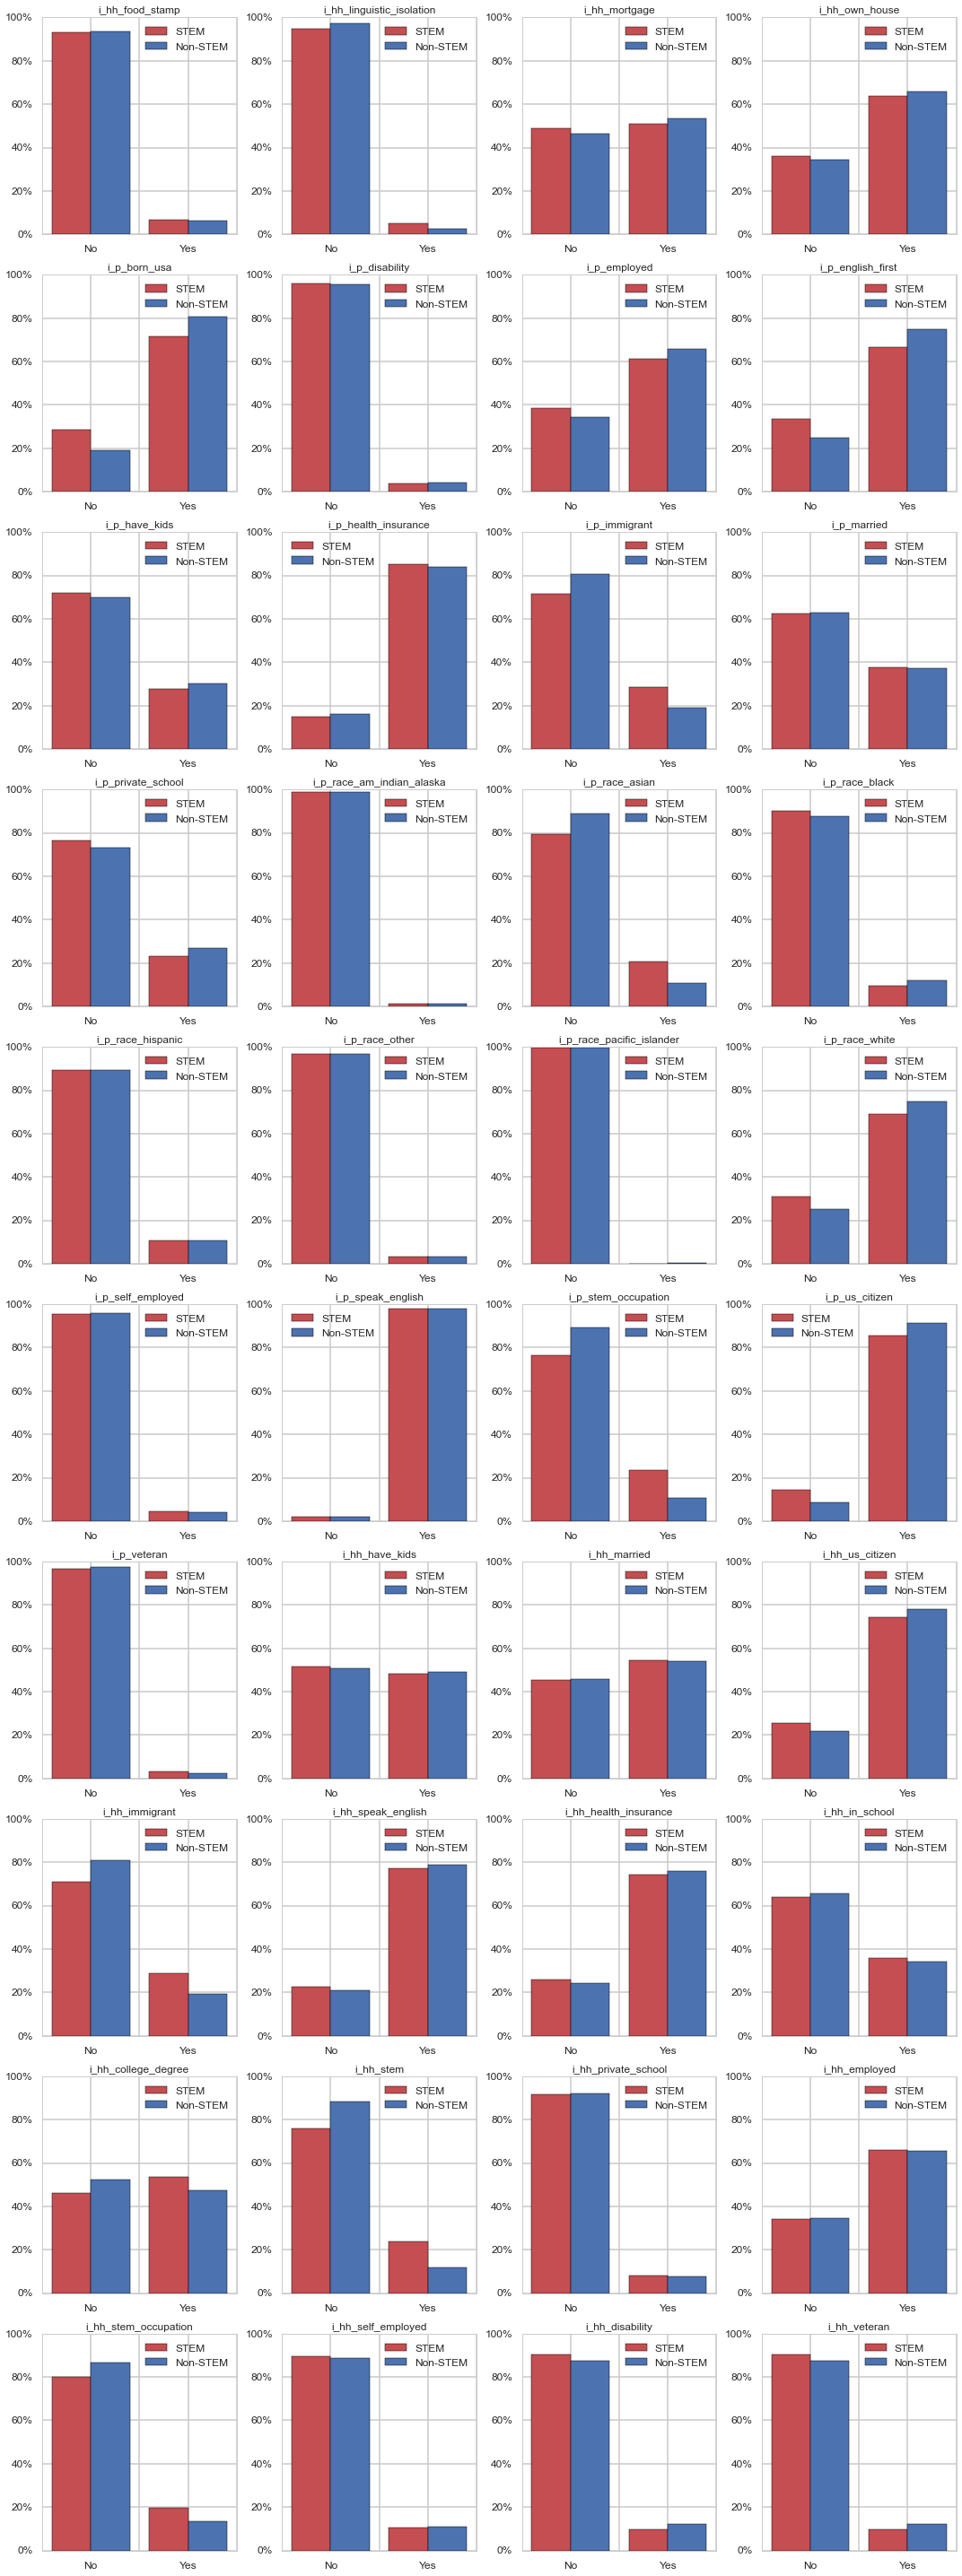

In [86]:
# check for trends in indicator variables
figIndicators, axes = plt.subplots(nrows=10, ncols=4, figsize=(15, 40), tight_layout=True)

for axis, feature in zip(axes.ravel(), INDICATOR_VARS_MODEL):
    countsSTEM = df5_female[feature][df5_female.i_p_stem==1]
    countsNonSTEM = df5_female[feature][df5_female.i_p_stem==0]
    featureSTEM = [(countsSTEM[countsSTEM==i].shape[0] * 100. / female_STEM) for i in range(2)]
    featureNonSTEM = [(countsNonSTEM[countsNonSTEM==i].shape[0] * 100. / female_nonSTEM) for i in range(2)]    
    axis.bar([-0.4, 0.6], featureSTEM, width=0.4, color=snsRed, label='STEM')
    axis.bar([0.0, 1.0], featureNonSTEM, width=0.4, color=snsBlue, label='Non-STEM')
    axis.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    axis.set_title(feature, fontsize=12)
    axis.set_xlim(xmin=-0.5, xmax=1.5)
    axis.set_ylim(ymin=0, ymax=100)
    axis.set_xticklabels(['', 'No', '', 'Yes', ''])
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

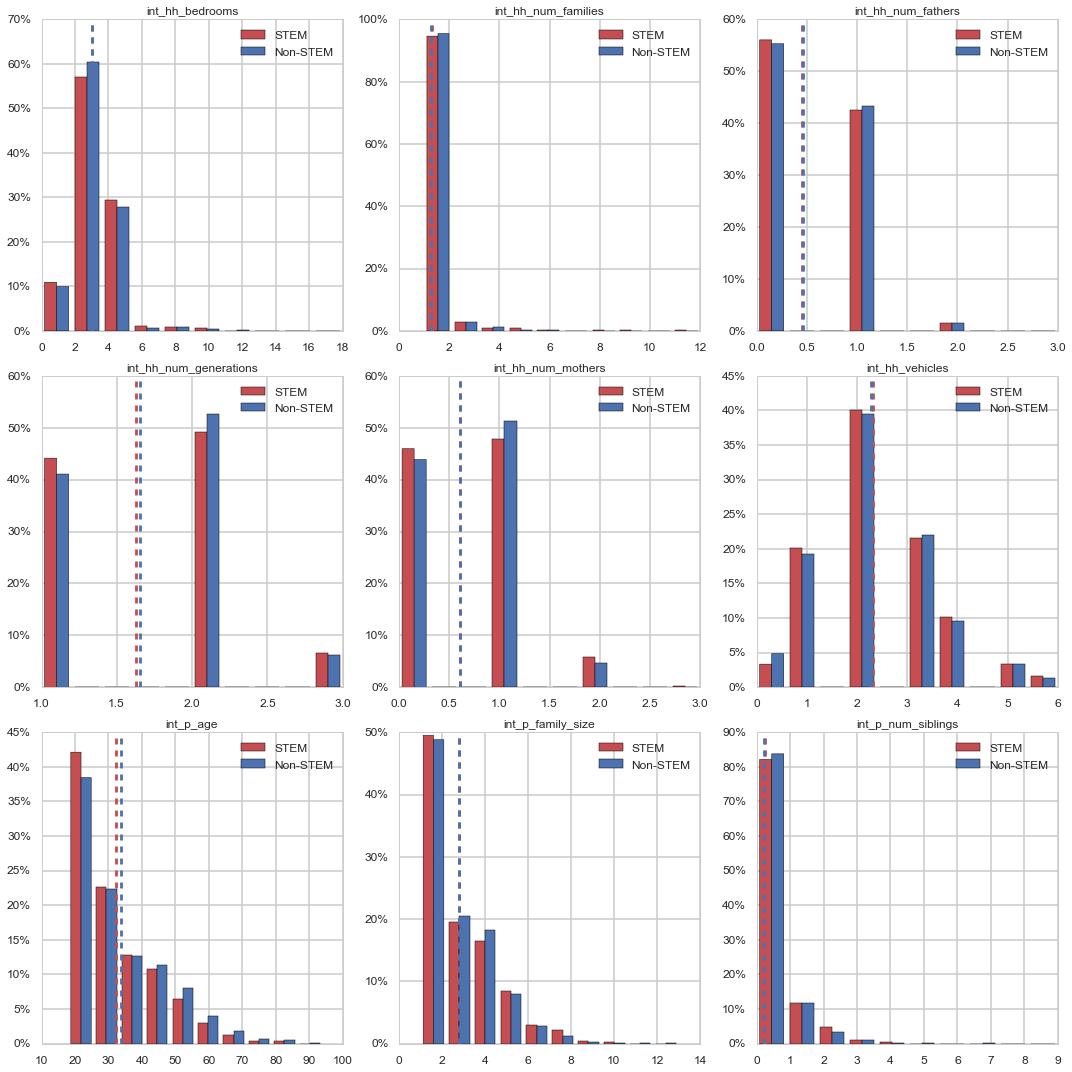

In [87]:
# check for trends in integer variables
figIntVars, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), tight_layout=True)

for axis, feature in zip(axes.ravel(), INTEGER_VARS):
    STEMResp = df5_female[feature][df5_female.i_p_stem==1].values
    NonSTEMResp = df5_female[feature][df5_female.i_p_stem==0].values
    STEMWeights = np.zeros_like(STEMResp) + 100. / STEMResp.size
    NonSTEMWeights = np.zeros_like(NonSTEMResp) + 100. / NonSTEMResp.size
    axis.hist([STEMResp, NonSTEMResp], weights=[STEMWeights, NonSTEMWeights], label=['STEM', 'Non-STEM'],
              color=[snsRed,snsBlue])
    axis.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    axis.axvline(x=STEMResp.mean(), linestyle='--', color=snsRed)
    axis.axvline(x=NonSTEMResp.mean(), linestyle='--', color=snsBlue)
    axis.set_title(feature, fontsize=12)
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


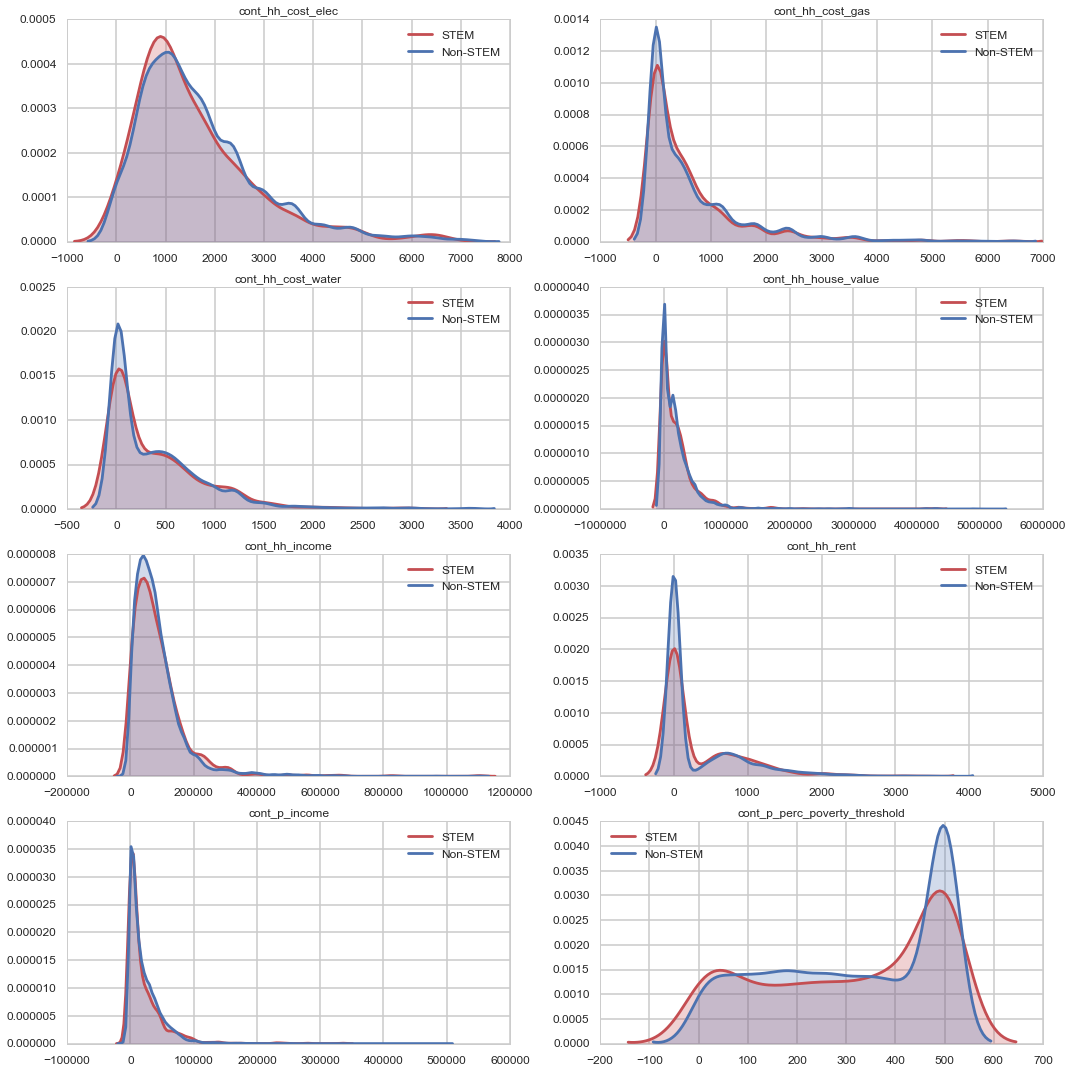

In [88]:
# check for trends in continuous variables
# note - not standardized yet
figContVars, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15), tight_layout=True)

for axis, feature in zip(axes.ravel(), CONTINUOUS_VARS):
    sns.kdeplot(df5_female[feature][df5_female.i_p_stem==1], shade=True, label='STEM', color=snsRed, ax=axis)
    sns.kdeplot(df5_female[feature][df5_female.i_p_stem==0], shade=True, label='Non-STEM', color=snsBlue, ax=axis)
    axis.set_title(feature, fontsize=12)
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

We first examined the breakdown of the indicator variables. Many distributions were roughly similar, although we did notice a few trends when comparing STEM to non-STEM female undergraduates.

* a higher proportion of STEM students were not born in the USA and/or are not US citizens
* a higher proportion of STEM students do not have english as a first language
* a higher proportion of STEM students are immigrants and/or have at least one household member that is an immigrant
* a higher proportion of STEM students are of Asian descent
* a lower proportion of STEM students are white
* a higher proportion of STEM students are already in a STEM occupation and/or have at least one household member in a STEM occupation
* a higher proportion of STEM students have at least one household member with a college degree and/or at least one household member with a degree in a STEM field

This indicates that immigrants or students of certain ethnic background may be more likely to enroll in STEM degrees. In addition, exposure to the field through a job or other household member also seems to make students more likely to study STEM.

We then examined the breakdown of integer (ordinal) variables. We observed fewer noticeable differences here, although it was interesting to note that STEM students appear to be marginally younger. We noticed the same (surprisingly) wide age distribution that we had observed during our exploratory data analysis.

The continuous variables were also roughly similar between STEM and non-STEM students, though we noticed that STEM students tended to have a broader distribution of values across the poverty threshold when compared to non-STEM students (i.e. there is less of a concentration among higher-income individuals). Not surprisingly, both categories peaked at higher income levels, which is consistent with a higher proportion of higher-income individuals attending college at all.

**4.3.2 Male Students**

In [89]:
# distribution of response variables for male students
male_STEM = df5_male[df5_male.i_p_stem==1].shape[0]
male_nonSTEM = df5_male[df5_male.i_p_stem==0].shape[0]
male_students = male_STEM + male_nonSTEM
male_students, male_STEM, male_nonSTEM

(5129, 1348, 3781)

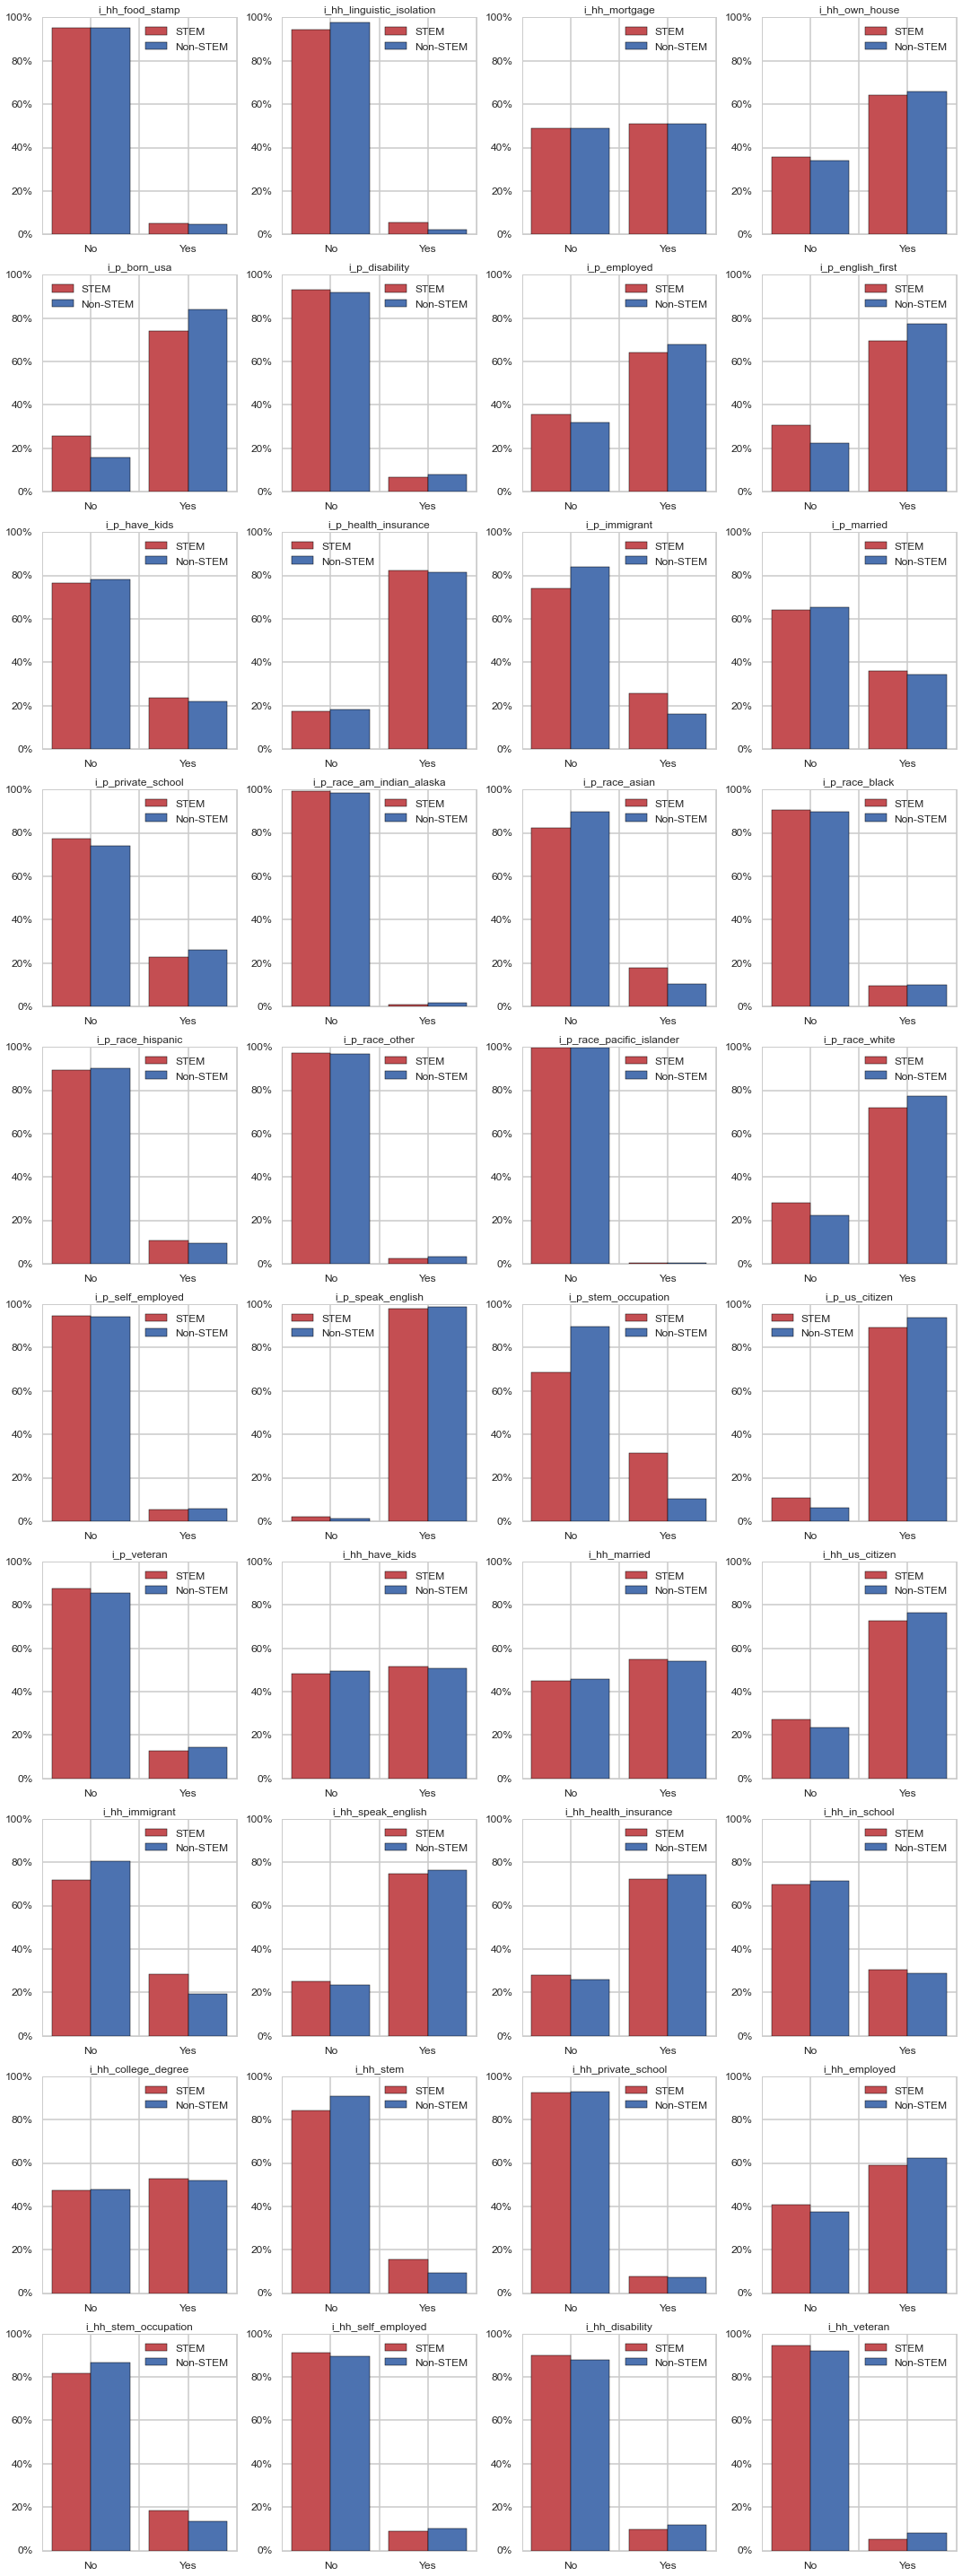

In [90]:
# check for trends in indicator variables
figIndicators, axes = plt.subplots(nrows=10, ncols=4, figsize=(15, 40), tight_layout=True)

for axis, feature in zip(axes.ravel(), INDICATOR_VARS_MODEL):
    countsSTEM = df5_male[feature][df5_male.i_p_stem==1]
    countsNonSTEM = df5_male[feature][df5_male.i_p_stem==0]
    featureSTEM = [(countsSTEM[countsSTEM==i].shape[0] * 100. / male_STEM) for i in range(2)]
    featureNonSTEM = [(countsNonSTEM[countsNonSTEM==i].shape[0] * 100. / male_nonSTEM) for i in range(2)]    
    axis.bar([-0.4, 0.6], featureSTEM, width=0.4, color=snsRed, label='STEM')
    axis.bar([0.0, 1.0], featureNonSTEM, width=0.4, color=snsBlue, label='Non-STEM')
    axis.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    axis.set_title(feature, fontsize=12)
    axis.set_xlim(xmin=-0.5, xmax=1.5)
    axis.set_ylim(ymin=0, ymax=100)
    axis.set_xticklabels(['', 'No', '', 'Yes', ''])
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

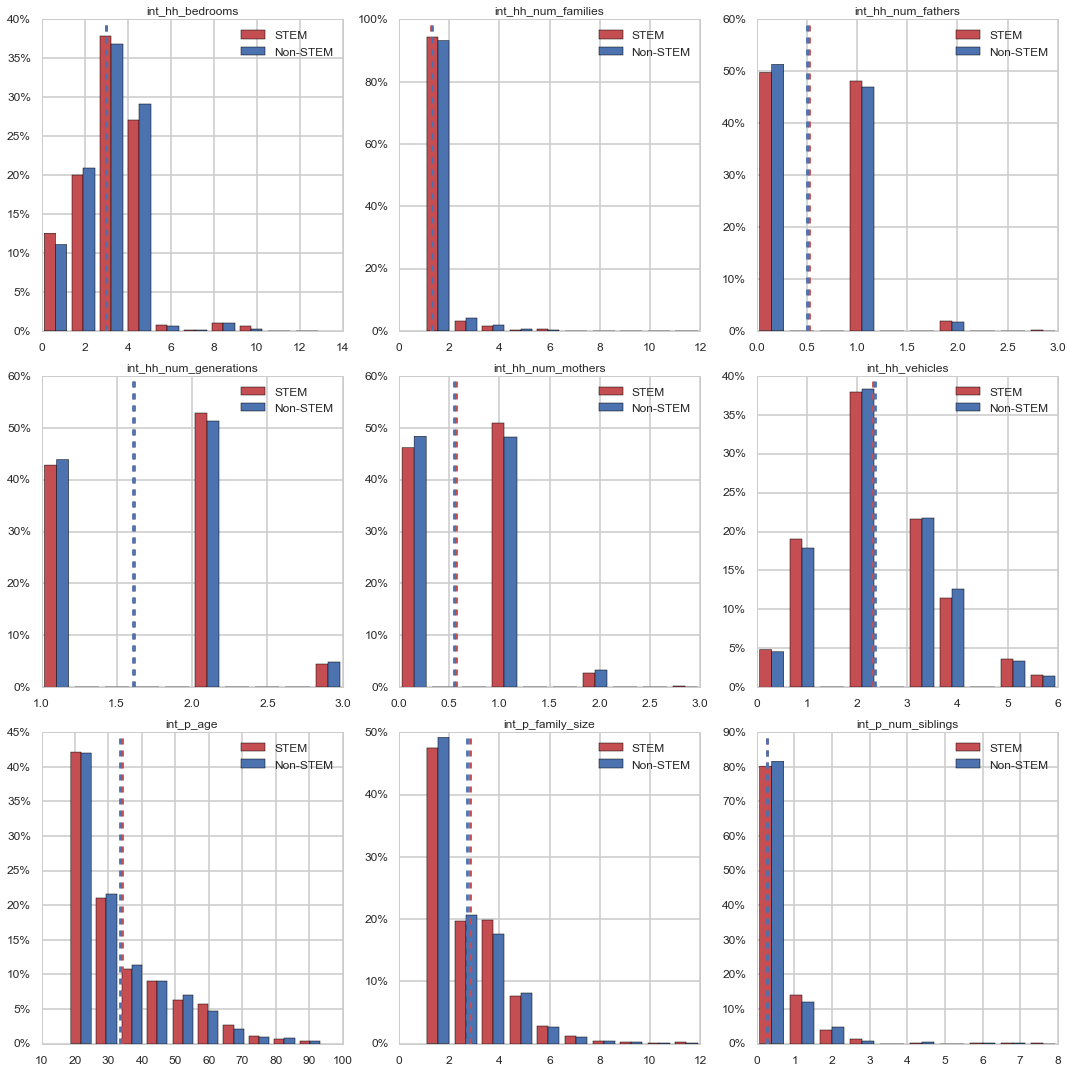

In [91]:
# check for trends in integer variables
figIntVars, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), tight_layout=True)

for axis, feature in zip(axes.ravel(), INTEGER_VARS):
    STEMResp = df5_male[feature][df5_male.i_p_stem==1].values
    NonSTEMResp = df5_male[feature][df5_male.i_p_stem==0].values
    STEMWeights = np.zeros_like(STEMResp) + 100. / STEMResp.size
    NonSTEMWeights = np.zeros_like(NonSTEMResp) + 100. / NonSTEMResp.size
    axis.hist([STEMResp, NonSTEMResp], weights=[STEMWeights, NonSTEMWeights], label=['STEM', 'Non-STEM'],
              color=[snsRed,snsBlue])
    axis.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    axis.axvline(x=STEMResp.mean(), linestyle='--', color=snsRed)
    axis.axvline(x=NonSTEMResp.mean(), linestyle='--', color=snsBlue)
    axis.set_title(feature, fontsize=12)
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

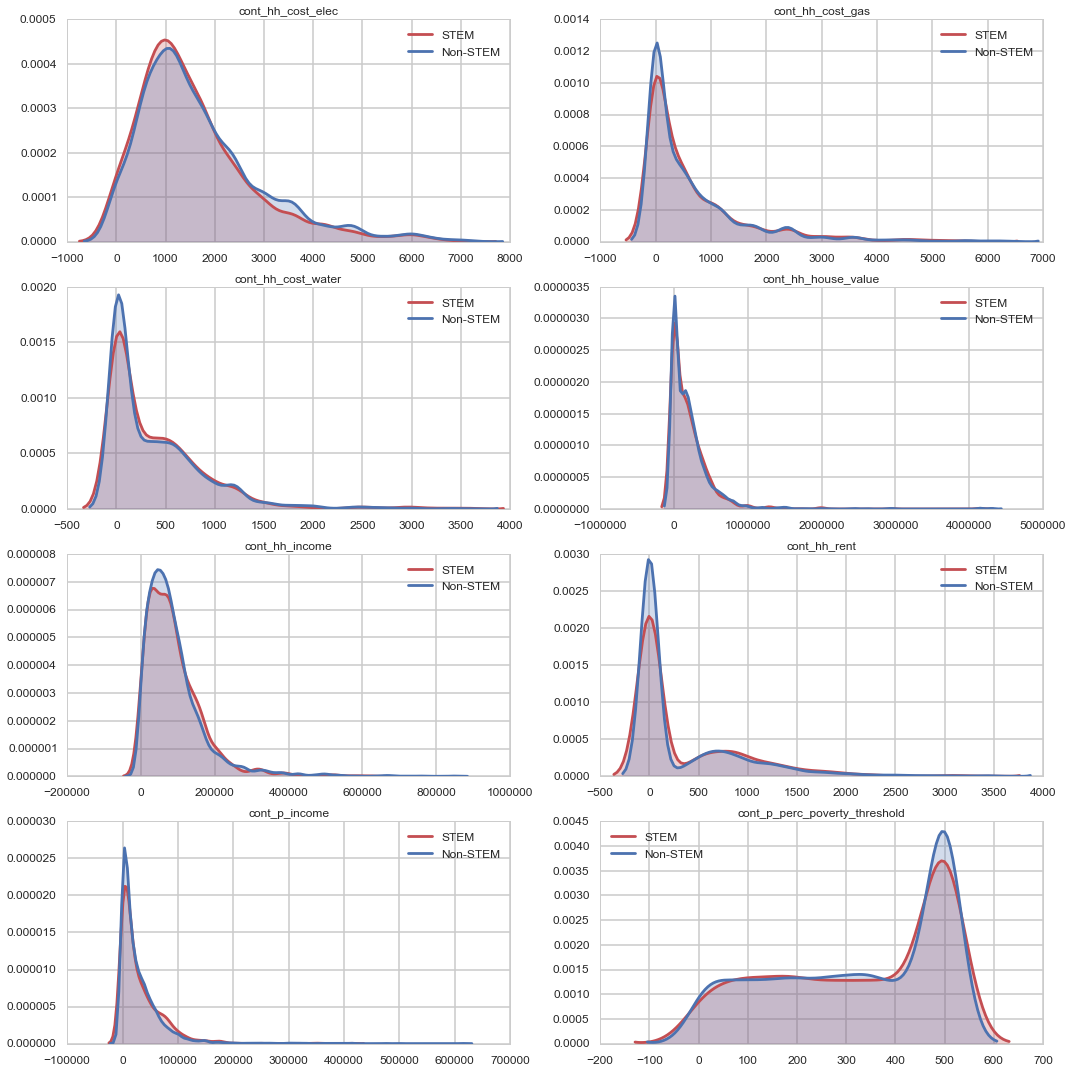

In [92]:
# check for trends in continuous variables
# note - not standardized
figContVars, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15), tight_layout=True)

for axis, feature in zip(axes.ravel(), CONTINUOUS_VARS):
    sns.kdeplot(df5_male[feature][df5_male.i_p_stem==1], shade=True, label='STEM', color=snsRed, ax=axis)
    sns.kdeplot(df5_male[feature][df5_male.i_p_stem==0], shade=True, label='Non-STEM', color=snsBlue, ax=axis)
    axis.set_title(feature, fontsize=12)
    axis.legend(loc='best', fontsize=12)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontsize(12)

For comparison purposes, we also plotted the same features for the male undergraduate students. It was interesting to notice some similarities, including a higher proportion of students that:

* were not born in the USA
* are not US citizens
* do not have english as a first language
* are of Asian descent and/or are not white
* are already in a STEM occupation
* have at least one household member with a STEM degree or that works in STEM

Again, there appears to be an association between STEM students and certain demographic characteristics, as well as exposure to the field through prior work experience or a household member.

The integer and continuous variables did not yield significant observable trends.

**4.3.3 Age Distribution**

As mentioned above, we were surprised to see the very wide range of ages of individuals that identified as being college undergraduates at the time of the census. While there is indeed a cluster of students in their early 20s (35% of female students across disciplines are under 25), the mean age is surprisingly high at 33. 

We initially considered applying an age cut-off to the data in order to focus on younger students, but we decide to move forward with the analysis with the entire dataset. This decision reflected our overarching interest in identifying factors that drive women in STEM - at any age.

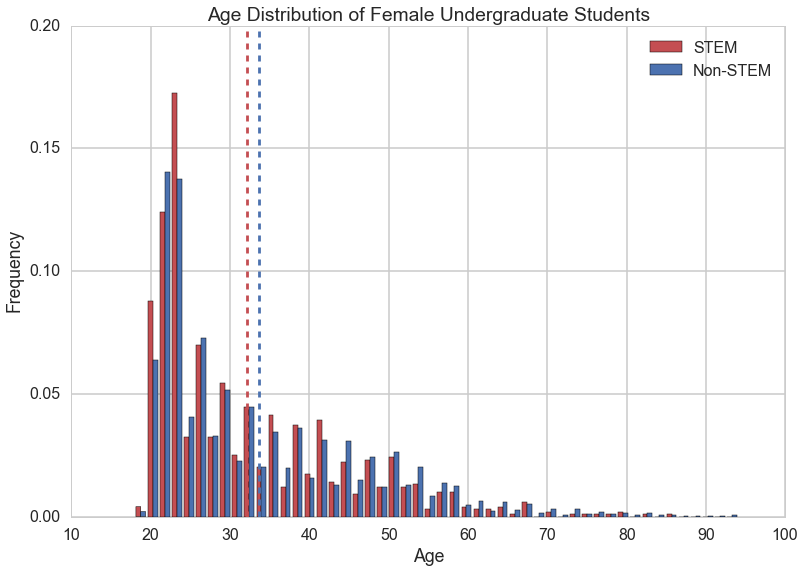

In [93]:
feature = 'int_p_age'

STEMResp = df5_female[feature][df5_female.i_p_stem==1].values
NonSTEMResp = df5_female[feature][df5_female.i_p_stem==0].values
STEMWeights = np.zeros_like(STEMResp) + 1. / STEMResp.size
NonSTEMWeights = np.zeros_like(NonSTEMResp) + 1. / NonSTEMResp.size

plt.hist([STEMResp, NonSTEMResp], weights=[STEMWeights, NonSTEMWeights], label=['STEM', 'Non-STEM'],
         bins=50, color=[snsRed,snsBlue])
plt.title('Age Distribution of Female Undergraduate Students')
plt.vlines(x=STEMResp.mean(), ymin=0, ymax=1, linestyle='--', color=snsRed)
plt.vlines(x=NonSTEMResp.mean(), ymin=0, ymax=1, linestyle='--', color=snsBlue)
plt.ylim(ymin=0, ymax=0.2)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

In [99]:
# move forward with students of all ages
df6_female = df5_female.copy()
df6_male = df5_male.copy()

###4.4 Rebalancing Classes

Due to the very nature of our research question, our final dataset was very unbalanced, with only 13% of female students majoring in STEM subjects. The male student dataset was also unbalanced, though to a lesser extent, with 26% of students studying STEM.

This inbalance meant that we would not be able to use an accuracy measure in order to assess the models we planned to build. To address the problem, we rebalanced the class for both the female and male datasets via over-sampling, a technique that is well-suited to the problem because it does not introduce bias.

**4.4.1 Female Students**

In [100]:
# determine number of samples required
num_STEM = df6_female[df6_female.i_p_stem==1].shape[0]
num_nonSTEM = df6_female[df6_female.i_p_stem==0].shape[0]
print '%.2f percent STEM students' % (num_STEM * 100. / (num_STEM + num_nonSTEM))
samples_required = num_nonSTEM - num_STEM
print '%d additional samples required to balance classes' % (samples_required)

12.61 percent STEM students
5873 additional samples required to balance classes


In [101]:
# non-parametric bootstrap
# randomly sample with replacement from female STEM fields
new_samples = df6_female[df6_female.i_p_stem==1].sample(n=samples_required, replace=2, axis=0)
dftomodel_femaleall = pd.concat([df6_female, new_samples])

In [102]:
# check split
dftomodel_femaleall[dftomodel_femaleall.i_p_stem==1].shape[0], dftomodel_femaleall[dftomodel_femaleall.i_p_stem==0].shape[0]

(6863, 6863)

In [103]:
dftomodel_femaleall.shape

(13726, 69)

In [104]:
dftomodel_femaleall.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
0,2160,480,600,56000,25200,0,4700,147,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,4,1,1,2,0,2,20,3,1,105,62,1,2,0,0,68
1,2160,480,60,540000,131100,0,2100,501,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,4,1,1,2,1,3,21,4,1,493,76,1,3,2,0,93
2,2400,0,30,15000,24800,0,16400,191,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,4,1,0,2,1,1,45,2,0,747,27,0,2,1,0,45
3,0,0,0,0,76800,2200,4800,501,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,3,1,0,1,0,3,46,2,0,816,27,0,1,0,2,27
4,960,960,600,114000,43900,0,34500,303,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,1,0,1,0,2,28,2,0,1607,21,0,2,0,1,24


In [105]:
# save clean dataset
# dftomodel_femaleall.to_csv('data/dftomodel_femaleall.csv')

**4.4.1 Male Students**

In [106]:
# determine number of samples required
num_STEM = df6_male[df6_male.i_p_stem==1].shape[0]
num_nonSTEM = df6_male[df6_male.i_p_stem==0].shape[0]
print '%.2f percent STEM students' % (num_STEM * 100. / (num_STEM + num_nonSTEM))
samples_required = num_nonSTEM - num_STEM
print '%d additional samples required to balance classes' % (samples_required)

26.28 percent STEM students
2433 additional samples required to balance classes


In [107]:
# non-parametric bootstrap
# randomly sample with replacement from male STEM fields
new_samples = df6_male[df6_male.i_p_stem==1].sample(n=samples_required, replace=2, axis=0)
dftomodel_maleall = pd.concat([df6_male, new_samples])

In [108]:
# check split
dftomodel_maleall[dftomodel_maleall.i_p_stem==1].shape[0], dftomodel_maleall[dftomodel_maleall.i_p_stem==0].shape[0]

(3781, 3781)

In [109]:
dftomodel_maleall.shape

(7562, 69)

In [110]:
dftomodel_maleall.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
0,2400,0,30,165000,87000,0,45000,396,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,0,1,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,1,0,3,1,1,2,1,3,33,4,0,80,60,0,1,0,2,60
1,2760,360,20,350000,135000,0,60000,501,1,0,1,0,1,1,0,1,0,1,1,1,1,0,1,0,0,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,1,0,3,1,1,2,1,2,34,4,0,160,53,0,2,0,1,51
2,0,0,0,0,26000,0,12000,106,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,2,2,0,1,0,3,22,1,0,359,16,0,1,0,0,17
3,3720,48,300,290000,231500,0,2500,501,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,4,1,1,2,1,4,24,3,0,430,84,1,3,2,0,104
4,960,720,300,0,35500,250,35500,316,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,1,0,1,0,2,24,1,0,1051,66,0,1,0,0,67


In [111]:
# save clean dataset
# dftomodel_maleall.to_csv('data/dftomodel_maleall.csv')

 <a id = "section5"></a>
 ##5. Logistic Regression

 <a id = "section6"></a>
 ##6. Random Forest

 <a id = "section7"></a>
 ##7. Discussion and Takeaways